# YouTube Video Performance Analysis with K-Means Clustering

This notebook analyzes YouTube video performance data to:
1. Identify best and worst performing videos
2. Understand factors contributing to performance
3. Discover trending keywords and topics
4. Use k-means clustering to group similar videos

## Data Sources
- `Chart data.csv` - Time-series view data per video
- `Totals.csv` - Aggregated daily totals
- `table data.csv` - Video-level performance metrics

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("Libraries imported successfully!")

Libraries imported successfully!


## 1. Load and Explore Data

In [2]:
# Load datasets
chart_data = pd.read_csv('Chart data.csv')
totals = pd.read_csv('Totals.csv')
table_data = pd.read_csv('table data.csv')

print("Dataset shapes:")
print(f"Chart data: {chart_data.shape}")
print(f"Totals: {totals.shape}")
print(f"Table data: {table_data.shape}")

Dataset shapes:
Chart data: (33305, 6)
Totals: (6661, 2)
Table data: (502, 10)


In [3]:
# Display table data structure (most useful for clustering)
print("\nTable Data Columns:")
print(table_data.columns.tolist())
print("\nFirst few rows:")
table_data.head(10)


Table Data Columns:
['Content', 'Video title', 'Video publish time', 'Duration', 'Views', 'Watch time (hours)', 'Subscribers', 'Estimated revenue (GBP)', 'Impressions', 'Impressions click-through rate (%)']

First few rows:


,Content,Video title,Video publish time,Duration,Views,Watch time (hours),Subscribers,Estimated revenue (GBP),Impressions,Impressions click-through rate (%)
0,Total,NaN,NaN,NaN,3467202.0,230096.9112,43908.0,10280.583,38436766.0,4.17
1,Y5atyJbVsAU,Build Your Own AI Assistant Part 1 - Creating ...,"Apr 19, 2021",4056.0,122706.0,8443.1417,2794.0,425.883,969012.0,4.61
2,hiVcgUdjy0A,"Node-Red Automation, MQTT, NodeMCU & MicroPython","Mar 29, 2021",5930.0,54610.0,7699.5005,919.0,195.374,802944.0,3.78
3,0sPPxIq4hg8,Build your own web server using a Raspberry Pi...,"Aug 29, 2022",4424.0,50652.0,7095.1844,722.0,237.040,691351.0,3.76
4,tDENgLiJSh0,Creating a Supercomputer with a Raspberry Pi 5...,"Feb 5, 2024",3411.0,63065.0,6571.4059,823.0,228.882,461448.0,6.47
5,H6CNmnT6kGo,How to Design PCBs with Fusion 360 in less tha...,"Aug 7, 2023",4515.0,34504.0,5882.6747,399.0,220.562,401114.0,4.14
6,KPfBOGjJdqE,Control Arduino with Python using Firmata / P...,"Aug 2, 2021",2123.0,89539.0,5443.2818,1113.0,217.496,887478.0,6.24
7,NmpcKv91LLs,Raspberry Pi 5 Mastery: Create a Powerful Home...,"Jan 22, 2024",4138.0,42402.0,4356.0684,629.0,160.285,303837.0,5.22
8,dfquulcbD7M,"Raspberry Pi 5 Projects, you have to make","Oct 16, 2023",2582.0,54918.0,4231.5275,602.0,187.339,462369.0,7.36
9,Q3OYCg-Ak4Q,Is the new Raspberry Pi AI Kit better than Goo...,"Jun 4, 2024",228.0,142146.0,4198.0896,1040.0,268.427,1450564.0,6.50


In [4]:
# Check for missing values
print("Missing values in table data:")
print(table_data.isnull().sum())

# Basic statistics
print("\nBasic statistics:")
table_data.describe()

Missing values in table data:
Content                                0
Video title                            2
Video publish time                    17
Duration                               2
Views                                  1
Watch time (hours)                     1
Subscribers                            1
Estimated revenue (GBP)                3
Impressions                            1
Impressions click-through rate (%)     1
dtype: int64

Basic statistics:


,Duration,Views,Watch time (hours),Subscribers,Estimated revenue (GBP),Impressions,Impressions click-through rate (%)
count,500.000000,5.010000e+02,501.000000,501.000000,499.000000,5.010000e+02,501.000000
mean,2360.296000,1.382646e+04,918.444033,158.133733,39.585206,1.531111e+05,3.229242
std,1918.048542,1.551115e+05,10303.087373,1967.329428,461.000127,1.718014e+06,1.802510
min,8.000000,9.700000e+01,3.044000,-2.000000,0.004000,8.010000e+02,0.200000
25%,343.500000,1.356000e+03,50.042600,6.000000,1.500500,2.667200e+04,2.040000
50%,2534.500000,3.067000e+03,164.054300,18.000000,6.435000,4.047400e+04,2.890000
75%,3875.250000,6.811000e+03,401.498000,56.000000,18.310000,7.845000e+04,4.080000
max,11816.000000,3.467202e+06,230096.911200,43908.000000,10280.583000,3.843677e+07,20.100000


## 2. Data Preprocessing

In [5]:
# Clean the data - remove the 'Total' row if it exists
df = table_data[table_data['Content'] != 'Total'].copy()

# Convert date columns - handle different date formats
df['Video publish time'] = pd.to_datetime(df['Video publish time'], errors='coerce')

# Drop rows with invalid dates
df = df[df['Video publish time'].notna()].copy()

# Calculate days since publication
today = datetime.now()
df['days_since_publish'] = (today - df['Video publish time']).dt.days

# Ensure days_since_publish is valid (no negative or zero values)
df['days_since_publish'] = df['days_since_publish'].apply(lambda x: max(x, 1))

# Calculate derived metrics
df['avg_view_duration'] = (df['Watch time (hours)'] * 60 / df['Views']).fillna(0)  # minutes
df['views_per_day'] = df['Views'] / df['days_since_publish']
df['revenue_per_view'] = df['Estimated revenue (GBP)'] / df['Views']
df['subscriber_conversion'] = df['Subscribers'] / df['Views'] * 100
df['clicks_per_impression'] = df['Impressions click-through rate (%)']

# Handle infinite values
df = df.replace([np.inf, -np.inf], np.nan)
df = df.fillna(0)

print(f"Cleaned dataset shape: {df.shape}")
print(f"Total unique videos: {len(df)}")

Cleaned dataset shape: (485, 16)
Total unique videos: 485


## 3. Extract Keywords from Titles

In [6]:
# Extract keywords from video titles
from collections import Counter
import re

# Expanded stop words to exclude verbs, articles, prepositions, and common non-topic words
stop_words = {
    # Articles, prepositions, conjunctions
    'the', 'a', 'an', 'and', 'or', 'but', 'in', 'on', 'at', 'to', 'for', 
    'of', 'with', 'by', 'from', 'up', 'about', 'into', 'through', 'during',
    'before', 'after', 'above', 'below', 'between', 'under', 'over',
    
    # Pronouns
    'your', 'you', 'it', 'this', 'that', 'these', 'those', 'my', 'our',
    'their', 'his', 'her', 'its', 'we', 'they', 'them',
    
    # Common verbs (especially those in video titles)
    'how', 'is', 'are', 'was', 'were', 'be', 'been', 'being',
    'have', 'has', 'had', 'do', 'does', 'did', 'will', 'would', 'could', 'should',
    'can', 'may', 'might', 'must', 'shall',
    'make', 'makes', 'making', 'made',
    'get', 'gets', 'getting', 'got',
    'use', 'uses', 'using', 'used',
    'need', 'needs', 'needed',
    'want', 'wants', 'wanted',
    'try', 'tries', 'trying', 'tried',
    'work', 'works', 'working', 'worked',
    'start', 'starts', 'starting', 'started',
    'run', 'runs', 'running', 'ran',
    'set', 'sets', 'setting',
    'install', 'installs', 'installing', 'installed',
    'create', 'creates', 'creating', 'created',
    'build', 'builds', 'building', 'built',
    'learn', 'learns', 'learning', 'learned',
    'take', 'takes', 'taking', 'took',
    'know', 'knows', 'knowing', 'knew',
    
    # Question words
    'what', 'when', 'where', 'why', 'which', 'who', 'whom', 'whose',
    
    # Common title words that aren't topics
    'guide', 'tutorial', 'tips', 'tricks', 'best', 'top', 'ultimate',
    'complete', 'full', 'step', 'easy', 'simple', 'quick', 'fast',
    'beginner', 'advanced', 'pro', 'master', 'course', 'lesson',
    'introduction', 'intro', 'overview', 'explained', 'understand',
    
    # Other common words
    'all', 'some', 'any', 'every', 'each', 'much', 'many', 'more', 'most',
    'other', 'such', 'than', 'too', 'very', 'just', 'now', 'only', 'also',
    'way', 'new', 'first', 'last', 'long', 'great', 'little', 'own', 'old',
    'right', 'big', 'high', 'different', 'small', 'large', 'next', 'early',
    'young', 'important', 'few', 'public', 'bad', 'same', 'able'
}

# Common topic keywords that should NOT be filtered (even if they look like verbs)
# These are actually nouns in the robotics/maker context
topic_overrides = {
    'build',  # "Build" as in physical construction (noun)
    'design', # "Design" as in CAD design (noun)
    'review', # "Review" as in product review (noun)
    'setup',  # "Setup" as in system setup (noun)
}

def extract_keywords(title):
    """Extract meaningful topic keywords from title"""
    # Convert to lowercase and split
    words = re.findall(r'\b[a-z]+\b', title.lower())
    
    # Filter out stop words and short words, but keep topic overrides
    keywords = [w for w in words 
                if (w not in stop_words or w in topic_overrides) 
                and len(w) > 2]
    
    return keywords

# Extract all keywords
all_keywords = []
for title in df['Video title']:
    all_keywords.extend(extract_keywords(str(title)))

# Count keyword frequency
keyword_counts = Counter(all_keywords)

print("Top 30 topic keywords across all videos:")
print("(Improved filtering - excluding verbs, articles, common words)")
print()
for keyword, count in keyword_counts.most_common(30):
    print(f"{keyword}: {count}")

Top 30 topic keywords across all videos:
(Improved filtering - excluding verbs, articles, common words)

raspberry: 159
robot: 91
pico: 82
micropython: 68
smars: 54
build: 45
part: 41
python: 32
arduino: 31
robots: 29
robotics: 26
fusion: 20
shorts: 19
pimoroni: 18
review: 17
raspberrypi: 17
design: 14
code: 13
bluetooth: 12
powered: 12
unboxing: 11
projects: 10
ros: 10
programming: 10
meet: 10
quad: 10
assistant: 9
kit: 9
zero: 9
camera: 9


In [7]:
# Add keywords to dataframe
df['keywords'] = df['Video title'].apply(lambda x: extract_keywords(str(x)))
df['keyword_string'] = df['keywords'].apply(lambda x: ', '.join(x))

# Create binary columns for top keywords
top_keywords = [kw for kw, count in keyword_counts.most_common(20)]
for keyword in top_keywords:
    df[f'has_{keyword}'] = df['keywords'].apply(lambda x: 1 if keyword in x else 0)

print(f"\nAdded {len(top_keywords)} keyword features")


Added 20 keyword features


## 4. Analyze Trending Keywords

In [8]:
# Define recent videos (published in last 6 months)
six_months_ago = today - timedelta(days=180)
recent_videos = df[df['Video publish time'] > six_months_ago].copy()

print(f"Total videos: {len(df)}")
print(f"Recent videos (last 6 months): {len(recent_videos)}")

# Extract keywords from recent videos
recent_keywords = []
for title in recent_videos['Video title']:
    recent_keywords.extend(extract_keywords(str(title)))

recent_keyword_counts = Counter(recent_keywords)

# Calculate trending score (recent frequency vs overall frequency)
trending_scores = {}
for keyword in recent_keyword_counts:
    if keyword in keyword_counts and keyword_counts[keyword] >= 3:  # Must appear at least 3 times overall
        overall_freq = keyword_counts[keyword] / len(df)
        recent_freq = recent_keyword_counts[keyword] / len(recent_videos)
        trending_scores[keyword] = recent_freq / overall_freq if overall_freq > 0 else 0

# Sort by trending score
trending_keywords = sorted(trending_scores.items(), key=lambda x: x[1], reverse=True)[:20]

print("\nTrending Keywords (higher score = more popular recently):")
for keyword, score in trending_keywords:
    overall_count = keyword_counts[keyword]
    recent_count = recent_keyword_counts[keyword]
    print(f"{keyword}: Trending Score={score:.2f} (Overall: {overall_count}, Recent: {recent_count})")

Total videos: 485
Recent videos (last 6 months): 28

Trending Keywords (higher score = more popular recently):
drone: Trending Score=17.32 (Overall: 3, Recent: 3)
uno: Trending Score=17.32 (Overall: 4, Recent: 4)
nas: Trending Score=6.93 (Overall: 5, Recent: 2)
hands: Trending Score=5.77 (Overall: 3, Recent: 1)
touch: Trending Score=5.77 (Overall: 3, Recent: 1)
better: Trending Score=5.77 (Overall: 3, Recent: 1)
think: Trending Score=5.77 (Overall: 3, Recent: 1)
like: Trending Score=5.77 (Overall: 3, Recent: 1)
secrets: Trending Score=5.77 (Overall: 3, Recent: 1)
wish: Trending Score=5.77 (Overall: 3, Recent: 1)
wrong: Trending Score=5.77 (Overall: 3, Recent: 1)
power: Trending Score=5.77 (Overall: 3, Recent: 1)
alvik: Trending Score=5.77 (Overall: 3, Recent: 1)
docker: Trending Score=4.33 (Overall: 4, Recent: 1)
version: Trending Score=4.33 (Overall: 4, Recent: 1)
based: Trending Score=4.33 (Overall: 4, Recent: 1)
server: Trending Score=4.33 (Overall: 4, Recent: 1)
pcb: Trending Score

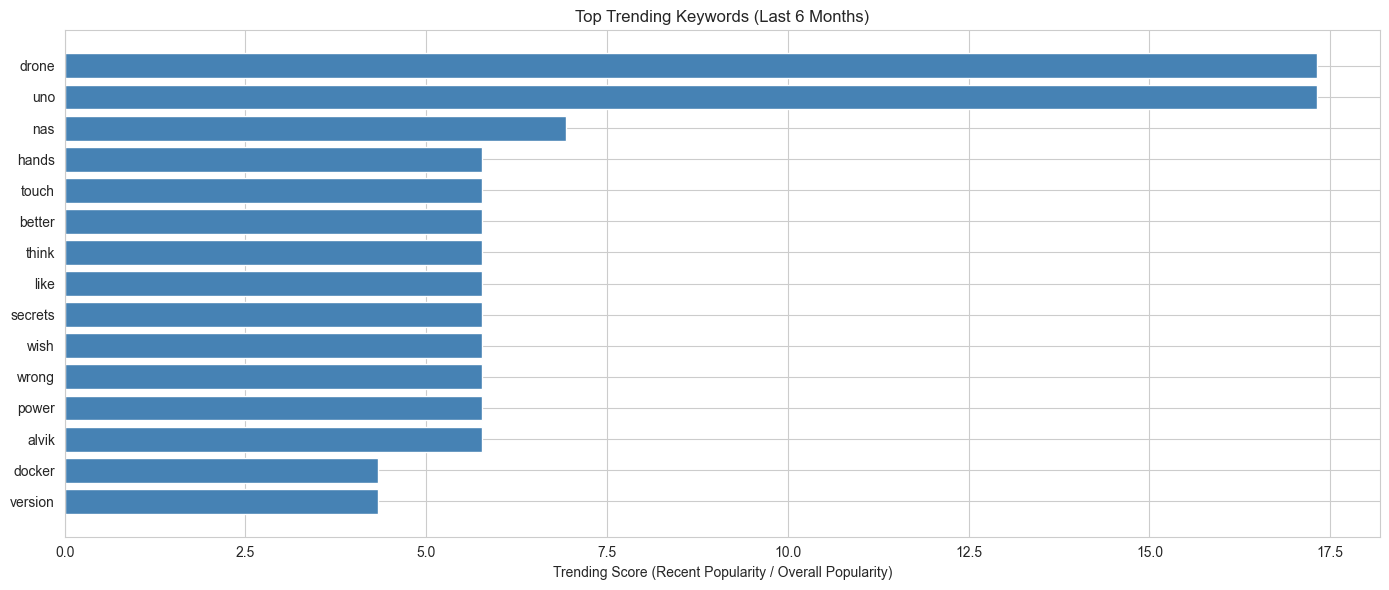

In [9]:
# Visualize trending keywords
trending_df = pd.DataFrame(trending_keywords, columns=['Keyword', 'Trending Score'])
trending_df = trending_df.head(15)

plt.figure(figsize=(14, 6))
plt.barh(trending_df['Keyword'], trending_df['Trending Score'], color='steelblue')
plt.xlabel('Trending Score (Recent Popularity / Overall Popularity)')
plt.title('Top Trending Keywords (Last 6 Months)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## 5. Performance Analysis - Best and Worst Videos

In [10]:
# Define composite performance score
# Normalize metrics to 0-1 scale
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
performance_metrics = ['Views', 'Watch time (hours)', 'Subscribers', 
                       'Estimated revenue (GBP)', 'Impressions click-through rate (%)',
                       'views_per_day', 'subscriber_conversion']

df_scaled = df.copy()
df_scaled[performance_metrics] = scaler.fit_transform(df[performance_metrics])

# Calculate composite performance score (weighted average)
weights = {
    'Views': 0.25,
    'Watch time (hours)': 0.20,
    'Subscribers': 0.15,
    'Estimated revenue (GBP)': 0.15,
    'Impressions click-through rate (%)': 0.10,
    'views_per_day': 0.10,
    'subscriber_conversion': 0.05
}

df['performance_score'] = sum(df_scaled[metric] * weight 
                               for metric, weight in weights.items())

# Sort by performance
df_sorted = df.sort_values('performance_score', ascending=False)

print("Top 10 Best Performing Videos:")
print("="*100)
top_10 = df_sorted.head(10)[['Video title', 'Views', 'Watch time (hours)', 
                               'Subscribers', 'performance_score']]
for idx, row in top_10.iterrows():
    print(f"\n{row['Video title'][:80]}")
    print(f"  Views: {row['Views']:,} | Watch Time: {row['Watch time (hours)']:.1f}h | "
          f"Subscribers: {row['Subscribers']:,} | Score: {row['performance_score']:.3f}")

Top 10 Best Performing Videos:

Build Your Own AI Assistant Part 1 - Creating the Assistant
  Views: 122,706.0 | Watch Time: 8443.1h | Subscribers: 2,794.0 | Score: 0.784

Is the new Raspberry Pi AI Kit better than Google Coral?
  Views: 142,146.0 | Watch Time: 4198.1h | Subscribers: 1,040.0 | Score: 0.592

Control Arduino with  Python using Firmata / PyFirmata
  Views: 89,539.0 | Watch Time: 5443.3h | Subscribers: 1,113.0 | Score: 0.484

Creating a Supercomputer with a Raspberry Pi 5 Cluster and Docker Swarm!
  Views: 63,065.0 | Watch Time: 6571.4h | Subscribers: 823.0 | Score: 0.461

Node-Red Automation, MQTT, NodeMCU & MicroPython
  Views: 54,610.0 | Watch Time: 7699.5h | Subscribers: 919.0 | Score: 0.446

Build your own web server using a Raspberry Pi Pico W using Phew!
  Views: 50,652.0 | Watch Time: 7095.2h | Subscribers: 722.0 | Score: 0.428

How to Map with LiDAR - using a Raspberry Pi Zero 2W, RPLidar and Rviz
  Views: 68,445.0 | Watch Time: 3671.1h | Subscribers: 881.0 | Scor

In [11]:
print("\n\nBottom 10 Worst Performing Videos:")
print("="*100)
bottom_10 = df_sorted.tail(10)[['Video title', 'Views', 'Watch time (hours)', 
                                  'Subscribers', 'performance_score']]
for idx, row in bottom_10.iterrows():
    print(f"\n{row['Video title'][:80]}")
    print(f"  Views: {row['Views']:,} | Watch Time: {row['Watch time (hours)']:.1f}h | "
          f"Subscribers: {row['Subscribers']:,} | Score: {row['performance_score']:.3f}")



Bottom 10 Worst Performing Videos:

Building the worlds most advanced Christmas Tree Bauble - Part 1
  Views: 543.0 | Watch Time: 19.0h | Subscribers: 2.0 | Score: 0.014

I made a chicken nugget Piano… using #circuitpython a #raspberrypipico and some 
  Views: 629.0 | Watch Time: 4.0h | Subscribers: 0.0 | Score: 0.013

SMARS Quad Morse Code #Shorts
  Views: 755.0 | Watch Time: 3.5h | Subscribers: 1.0 | Score: 0.013

GY-271 Soldering and 3d printing a module to fit it to a SMARS Robot
  Views: 673.0 | Watch Time: 11.7h | Subscribers: 0.0 | Score: 0.013

Halloween Spider - Part 1
  Views: 143.0 | Watch Time: 6.9h | Subscribers: 0.0 | Score: 0.012

We are the Robots! Here are a couple of builds from my robot lab. #shorts
  Views: 945.0 | Watch Time: 4.7h | Subscribers: 1.0 | Score: 0.012

What is Chat GPT 4? #python #robotics #ai
  Views: 841.0 | Watch Time: 4.4h | Subscribers: 0.0 | Score: 0.009

What does a robot see? Let’s find out! 🤖👀 #robotics #micropython #python #raspbe
  Views: 

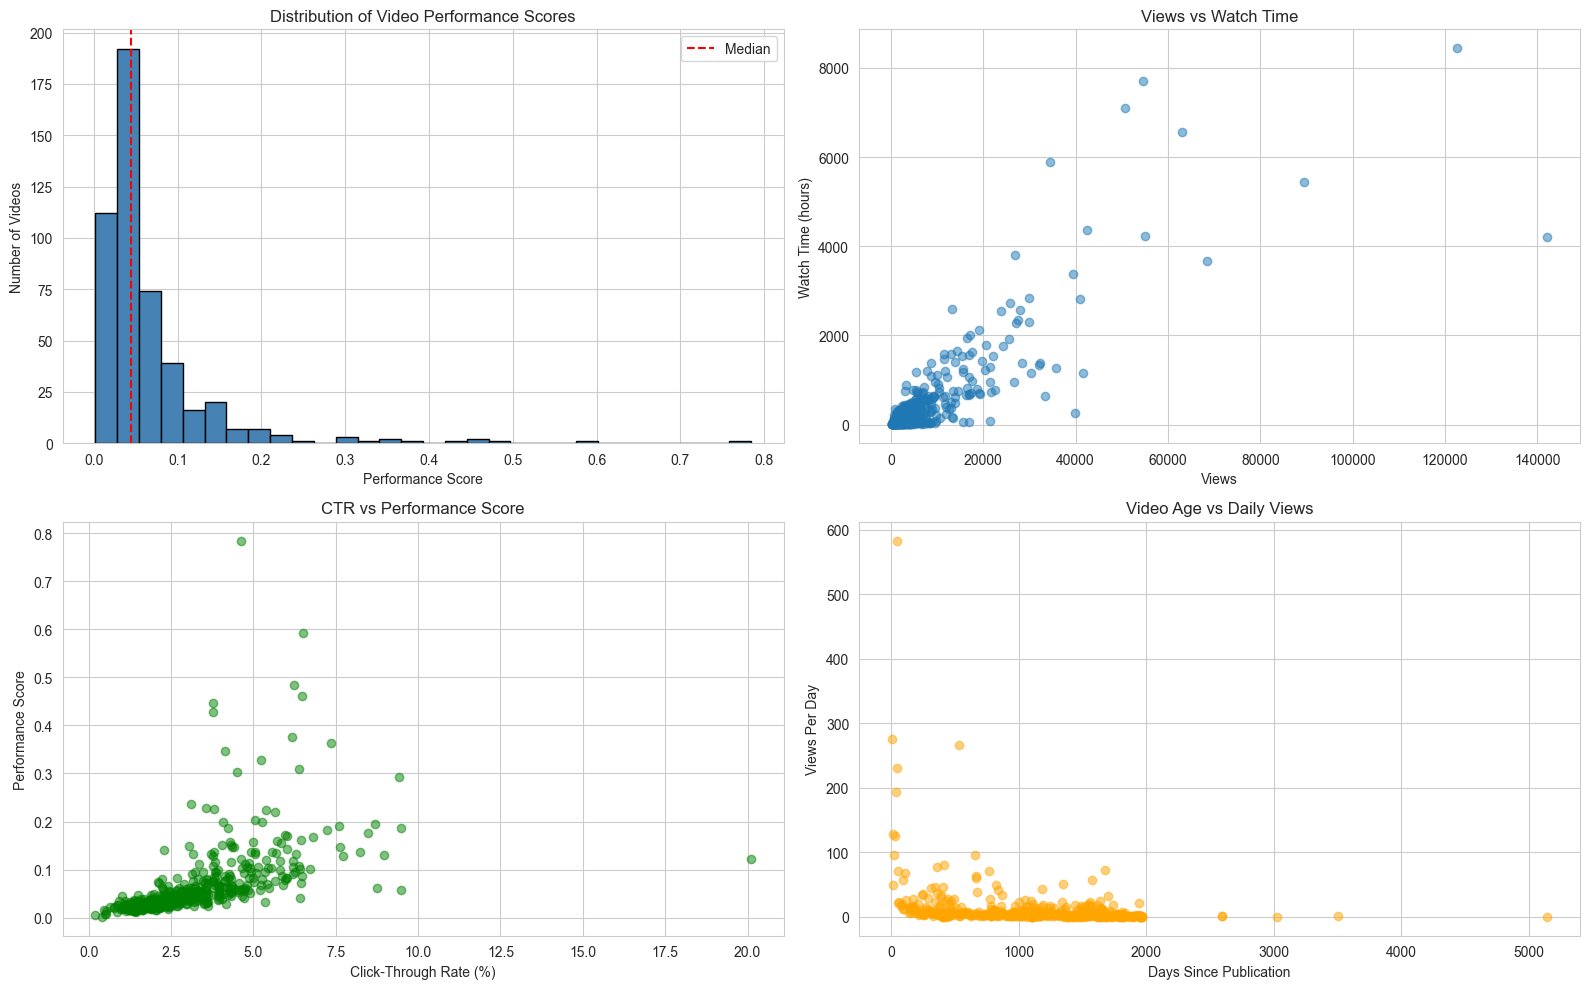

In [12]:
# Visualize performance distribution
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Performance score distribution
axes[0, 0].hist(df['performance_score'], bins=30, color='steelblue', edgecolor='black')
axes[0, 0].set_xlabel('Performance Score')
axes[0, 0].set_ylabel('Number of Videos')
axes[0, 0].set_title('Distribution of Video Performance Scores')
axes[0, 0].axvline(df['performance_score'].median(), color='red', 
                   linestyle='--', label='Median')
axes[0, 0].legend()

# Views vs Watch Time
axes[0, 1].scatter(df['Views'], df['Watch time (hours)'], alpha=0.5)
axes[0, 1].set_xlabel('Views')
axes[0, 1].set_ylabel('Watch Time (hours)')
axes[0, 1].set_title('Views vs Watch Time')

# CTR vs Performance Score
axes[1, 0].scatter(df['Impressions click-through rate (%)'], 
                   df['performance_score'], alpha=0.5, color='green')
axes[1, 0].set_xlabel('Click-Through Rate (%)')
axes[1, 0].set_ylabel('Performance Score')
axes[1, 0].set_title('CTR vs Performance Score')

# Views per day vs Days since publish
axes[1, 1].scatter(df['days_since_publish'], df['views_per_day'], alpha=0.5, color='orange')
axes[1, 1].set_xlabel('Days Since Publication')
axes[1, 1].set_ylabel('Views Per Day')
axes[1, 1].set_title('Video Age vs Daily Views')

plt.tight_layout()
plt.show()

## 6. K-Means Clustering Analysis

In [13]:
# Select features for clustering
clustering_features = [
    'Views',
    'Watch time (hours)',
    'Subscribers',
    'Estimated revenue (GBP)',
    'Impressions click-through rate (%)',
    'avg_view_duration',
    'views_per_day',
    'subscriber_conversion',
    'Duration'
]

# Prepare data for clustering
X = df[clustering_features].copy()

# Standardize features
scaler_cluster = StandardScaler()
X_scaled = scaler_cluster.fit_transform(X)

print(f"Clustering data shape: {X_scaled.shape}")
print(f"Features used: {clustering_features}")

Clustering data shape: (485, 9)
Features used: ['Views', 'Watch time (hours)', 'Subscribers', 'Estimated revenue (GBP)', 'Impressions click-through rate (%)', 'avg_view_duration', 'views_per_day', 'subscriber_conversion', 'Duration']


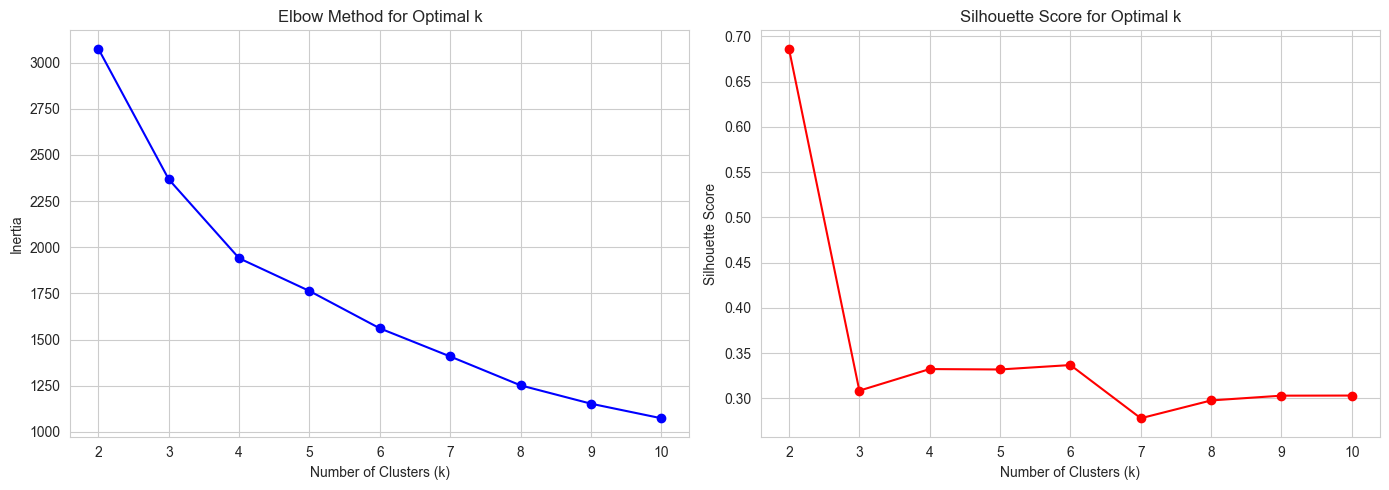


Recommended number of clusters: 2
Best silhouette score: 0.686


In [14]:
# Determine optimal number of clusters using elbow method
inertias = []
silhouette_scores = []
K_range = range(2, 11)

from sklearn.metrics import silhouette_score

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))

# Plot elbow curve
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(K_range, inertias, 'bo-')
axes[0].set_xlabel('Number of Clusters (k)')
axes[0].set_ylabel('Inertia')
axes[0].set_title('Elbow Method for Optimal k')
axes[0].grid(True)

axes[1].plot(K_range, silhouette_scores, 'ro-')
axes[1].set_xlabel('Number of Clusters (k)')
axes[1].set_ylabel('Silhouette Score')
axes[1].set_title('Silhouette Score for Optimal k')
axes[1].grid(True)

plt.tight_layout()
plt.show()

# Find best k based on silhouette score
best_k = K_range[np.argmax(silhouette_scores)]
print(f"\nRecommended number of clusters: {best_k}")
print(f"Best silhouette score: {max(silhouette_scores):.3f}")

In [15]:
# Perform k-means clustering with optimal k
optimal_k = 5  # You can adjust this based on the elbow plot
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df['cluster'] = kmeans.fit_predict(X_scaled)

print(f"Videos per cluster:")
print(df['cluster'].value_counts().sort_index())

Videos per cluster:
cluster
0     82
1    171
2     12
3    219
4      1
Name: count, dtype: int64


In [16]:
# Analyze cluster characteristics
cluster_analysis = df.groupby('cluster')[clustering_features + ['performance_score']].mean()
cluster_counts = df['cluster'].value_counts().sort_index()

print("\nCluster Characteristics (Average Values):")
print("="*120)
print(cluster_analysis.round(2))

# Name clusters based on characteristics
cluster_names = {}
for cluster_id in range(optimal_k):
    cluster_data = cluster_analysis.loc[cluster_id]
    
    if cluster_data['performance_score'] > 0.5:
        if cluster_data['Subscribers'] > cluster_analysis['Subscribers'].median():
            cluster_names[cluster_id] = "🌟 Star Performers (High Engagement)"
        else:
            cluster_names[cluster_id] = "📈 Viral Videos (High Views)"
    elif cluster_data['performance_score'] > 0.3:
        cluster_names[cluster_id] = "✅ Solid Performers"
    else:
        if cluster_data['views_per_day'] < cluster_analysis['views_per_day'].median():
            cluster_names[cluster_id] = "📉 Underperformers"
        else:
            cluster_names[cluster_id] = "🔄 Growing Videos"

df['cluster_name'] = df['cluster'].map(cluster_names)

print("\n\nCluster Names and Sizes:")
for cluster_id, name in cluster_names.items():
    count = cluster_counts[cluster_id]
    print(f"Cluster {cluster_id}: {name} ({count} videos)")


Cluster Characteristics (Average Values):
             Views  Watch time (hours)  Subscribers  Estimated revenue (GBP)  \
cluster                                                                        
0         16373.12             1143.96       186.01                    47.52   
1          4218.87               85.80        18.23                     4.60   
2         58703.58             4826.31       764.08                   181.85   
3          2583.92              250.83        22.69                     9.93   
4        122706.00             8443.14      2794.00                   425.88   

         Impressions click-through rate (%)  avg_view_duration  views_per_day  \
cluster                                                                         
0                                      5.44               4.48          24.00   
1                                      2.69               1.27           5.66   
2                                      5.83               5.71         1

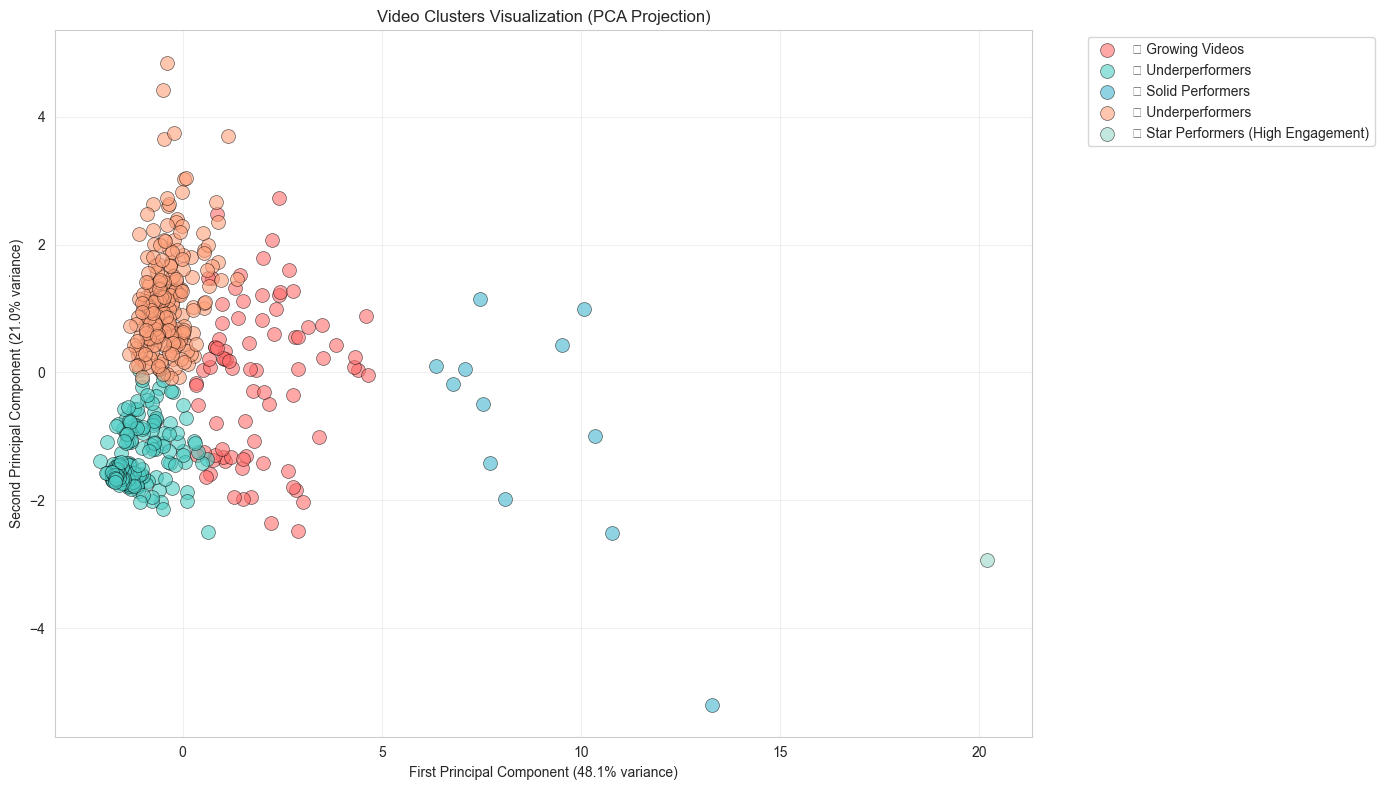

In [17]:
# Visualize clusters using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

df['pca1'] = X_pca[:, 0]
df['pca2'] = X_pca[:, 1]

plt.figure(figsize=(14, 8))
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#98D8C8']

for cluster_id in range(optimal_k):
    cluster_data = df[df['cluster'] == cluster_id]
    plt.scatter(cluster_data['pca1'], cluster_data['pca2'], 
                c=colors[cluster_id], label=cluster_names[cluster_id],
                alpha=0.6, s=100, edgecolors='black', linewidth=0.5)

plt.xlabel(f'First Principal Component ({pca.explained_variance_ratio_[0]:.1%} variance)')
plt.ylabel(f'Second Principal Component ({pca.explained_variance_ratio_[1]:.1%} variance)')
plt.title('Video Clusters Visualization (PCA Projection)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 7. Cluster Deep Dive

In [18]:
# Analyze each cluster in detail
for cluster_id in range(optimal_k):
    print(f"\n{'='*100}")
    print(f"Cluster {cluster_id}: {cluster_names[cluster_id]}")
    print(f"{'='*100}")
    
    cluster_videos = df[df['cluster'] == cluster_id].copy()
    
    # Summary statistics
    print(f"\nNumber of videos: {len(cluster_videos)}")
    print(f"Average performance score: {cluster_videos['performance_score'].mean():.3f}")
    print(f"Average views: {cluster_videos['Views'].mean():,.0f}")
    print(f"Average watch time: {cluster_videos['Watch time (hours)'].mean():.1f} hours")
    print(f"Average CTR: {cluster_videos['Impressions click-through rate (%)'].mean():.2f}%")
    
    # Top keywords in this cluster
    cluster_keywords = []
    for keywords in cluster_videos['keywords']:
        cluster_keywords.extend(keywords)
    
    cluster_keyword_counts = Counter(cluster_keywords)
    print(f"\nTop keywords in this cluster:")
    for keyword, count in cluster_keyword_counts.most_common(10):
        print(f"  - {keyword}: {count}")
    
    # Sample videos
    print(f"\nSample videos from this cluster:")
    sample = cluster_videos.nlargest(3, 'Views')[['Video title', 'Views', 'performance_score']]
    for idx, row in sample.iterrows():
        print(f"  • {row['Video title'][:70]}")
        print(f"    Views: {row['Views']:,} | Score: {row['performance_score']:.3f}")


Cluster 0: 🔄 Growing Videos

Number of videos: 82
Average performance score: 0.133
Average views: 16,373
Average watch time: 1144.0 hours
Average CTR: 5.44%

Top keywords in this cluster:
  - raspberry: 47
  - pico: 26
  - micropython: 20
  - python: 10
  - robot: 10
  - build: 9
  - part: 8
  - ros: 7
  - arduino: 5
  - camera: 5

Sample videos from this cluster:
  • Install MicroPython on ESP8266 & ESP32
    Views: 41,688.0 | Score: 0.194
  • Raspberry Pi Pico Wifi Module - how to add Wifi to your Pico Projects
    Views: 35,640.0 | Score: 0.191
  • Raspberry Pi AI Camera Module
    Views: 33,355.0 | Score: 0.162

Cluster 1: 📉 Underperformers

Number of videos: 171
Average performance score: 0.036
Average views: 4,219
Average watch time: 85.8 hours
Average CTR: 2.69%

Top keywords in this cluster:
  - raspberry: 41
  - robot: 29
  - micropython: 27
  - pico: 22
  - shorts: 19
  - part: 18
  - raspberrypi: 17
  - robotics: 15
  - smars: 14
  - build: 14

Sample videos from this clust

## 8. Success Factor Analysis

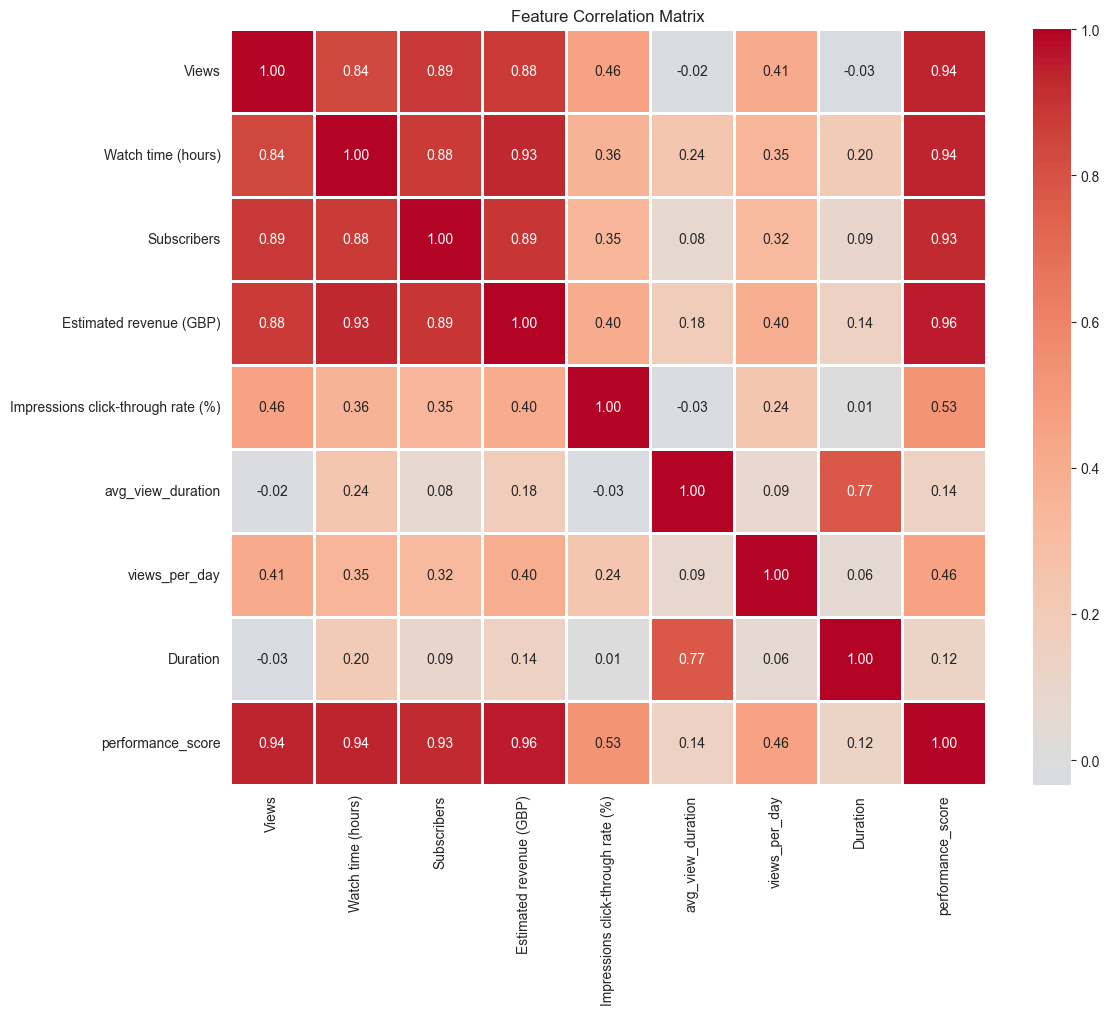


Strongest correlations with performance score:
  Estimated revenue (GBP): 0.955
  Watch time (hours): 0.943
  Views: 0.940
  Subscribers: 0.926
  Impressions click-through rate (%): 0.528
  views_per_day: 0.461
  avg_view_duration: 0.140
  Duration: 0.123


In [19]:
# Correlation analysis
correlation_features = [
    'Views', 'Watch time (hours)', 'Subscribers', 
    'Estimated revenue (GBP)', 'Impressions click-through rate (%)',
    'avg_view_duration', 'views_per_day', 'Duration', 'performance_score'
]

correlation_matrix = df[correlation_features].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=1)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

print("\nStrongest correlations with performance score:")
perf_correlations = correlation_matrix['performance_score'].sort_values(ascending=False)[1:]
for feature, corr in perf_correlations.items():
    print(f"  {feature}: {corr:.3f}")

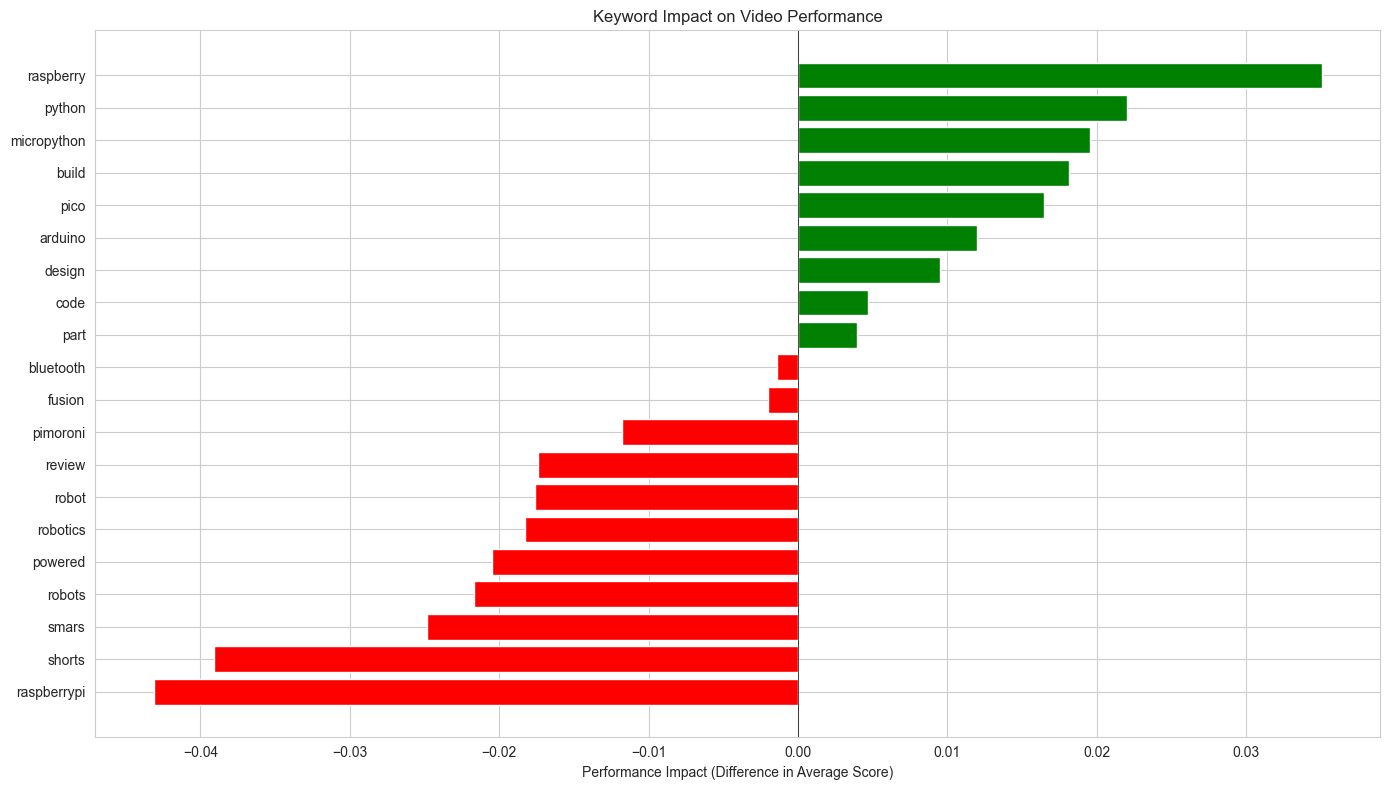


Keywords with highest positive impact:
    Keyword  Performance Impact
  raspberry            0.035050
     python            0.022023
micropython            0.019544
      build            0.018140
       pico            0.016497
    arduino            0.011990
     design            0.009500
       code            0.004719
       part            0.003942
  bluetooth           -0.001393


In [20]:
# Analyze impact of top keywords on performance
keyword_impact = {}
for keyword in top_keywords:
    has_keyword = df[df[f'has_{keyword}'] == 1]['performance_score'].mean()
    no_keyword = df[df[f'has_{keyword}'] == 0]['performance_score'].mean()
    keyword_impact[keyword] = has_keyword - no_keyword

keyword_impact_df = pd.DataFrame(list(keyword_impact.items()), 
                                  columns=['Keyword', 'Performance Impact'])
keyword_impact_df = keyword_impact_df.sort_values('Performance Impact', ascending=False)

plt.figure(figsize=(14, 8))
colors = ['green' if x > 0 else 'red' for x in keyword_impact_df['Performance Impact']]
plt.barh(keyword_impact_df['Keyword'], keyword_impact_df['Performance Impact'], color=colors)
plt.xlabel('Performance Impact (Difference in Average Score)')
plt.title('Keyword Impact on Video Performance')
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\nKeywords with highest positive impact:")
print(keyword_impact_df.head(10).to_string(index=False))

## 9. Trending Topics Analysis

In [21]:
# Analyze performance of trending keywords
trending_keyword_performance = {}

for keyword, _ in trending_keywords[:15]:
    # Get videos with this keyword
    videos_with_keyword = df[df['keywords'].apply(lambda x: keyword in x)]
    
    if len(videos_with_keyword) > 0:
        avg_perf = videos_with_keyword['performance_score'].mean()
        avg_views = videos_with_keyword['Views'].mean()
        count = len(videos_with_keyword)
        
        trending_keyword_performance[keyword] = {
            'avg_performance': avg_perf,
            'avg_views': avg_views,
            'video_count': count
        }

trending_perf_df = pd.DataFrame(trending_keyword_performance).T
trending_perf_df = trending_perf_df.sort_values('avg_performance', ascending=False)

print("\nTrending Keywords Performance Analysis:")
print("="*80)
print(f"{'Keyword':<20} {'Avg Performance':<18} {'Avg Views':<15} {'Video Count'}")
print("="*80)
for keyword, row in trending_perf_df.iterrows():
    print(f"{keyword:<20} {row['avg_performance']:<18.3f} {row['avg_views']:<15,.0f} {row['video_count']:.0f}")


Trending Keywords Performance Analysis:
Keyword              Avg Performance    Avg Views       Video Count
better               0.227              48,728          3
hands                0.163              12,372          3
docker               0.161              19,929          4
uno                  0.154              9,254           4
nas                  0.097              9,630           4
secrets              0.069              8,251           3
drone                0.066              4,300           2
alvik                0.063              4,256           3
touch                0.057              5,032           3
like                 0.052              4,274           3
version              0.052              4,054           4
think                0.049              2,983           3
power                0.038              3,197           3
wrong                0.029              1,026           3
wish                 0.024              1,826           2


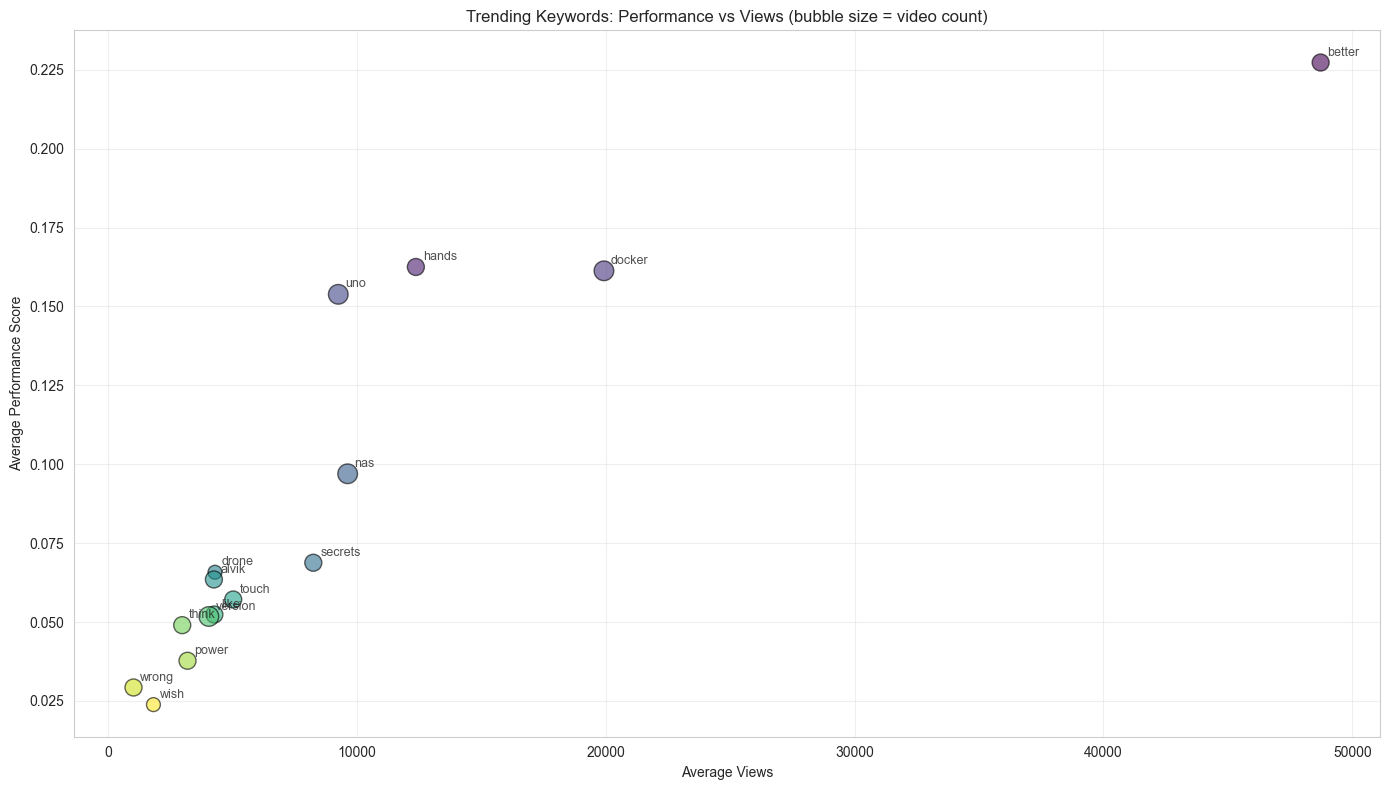

In [22]:
# Create a scatter plot of trending keywords
plt.figure(figsize=(14, 8))

scatter = plt.scatter(trending_perf_df['avg_views'], 
                      trending_perf_df['avg_performance'],
                      s=trending_perf_df['video_count']*50,
                      alpha=0.6, c=range(len(trending_perf_df)), cmap='viridis',
                      edgecolors='black', linewidth=1)

# Add labels
for keyword, row in trending_perf_df.iterrows():
    plt.annotate(keyword, 
                 (row['avg_views'], row['avg_performance']),
                 xytext=(5, 5), textcoords='offset points',
                 fontsize=9, alpha=0.8)

plt.xlabel('Average Views')
plt.ylabel('Average Performance Score')
plt.title('Trending Keywords: Performance vs Views (bubble size = video count)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 10. Recommendations and Insights

In [23]:
print("\n" + "="*100)
print("KEY INSIGHTS AND RECOMMENDATIONS")
print("="*100)

# 1. Best performing cluster
best_cluster = cluster_analysis['performance_score'].idxmax()
print(f"\n1. BEST PERFORMING CLUSTER: {cluster_names[best_cluster]}")
print(f"   - Average performance score: {cluster_analysis.loc[best_cluster, 'performance_score']:.3f}")
print(f"   - Average views: {cluster_analysis.loc[best_cluster, 'Views']:,.0f}")
print(f"   - Average CTR: {cluster_analysis.loc[best_cluster, 'Impressions click-through rate (%)']:.2f}%")

# 2. Top keywords to focus on
print("\n2. HIGH-IMPACT KEYWORDS TO FOCUS ON:")
top_impact_keywords = keyword_impact_df.head(5)
for _, row in top_impact_keywords.iterrows():
    print(f"   - {row['Keyword']}: +{row['Performance Impact']:.3f} impact")

# 3. Trending topics
print("\n3. TRENDING TOPICS (Most Popular Recently):")
for keyword, score in trending_keywords[:5]:
    print(f"   - {keyword}: Trending score {score:.2f}")

# 4. Success factors
print("\n4. KEY SUCCESS FACTORS (Strongest Correlations with Performance):")
top_correlations = perf_correlations.head(5)
for feature, corr in top_correlations.items():
    print(f"   - {feature}: {corr:.3f} correlation")

# 5. Improvement opportunities
worst_cluster = cluster_analysis['performance_score'].idxmin()
print(f"\n5. IMPROVEMENT OPPORTUNITIES: {cluster_names[worst_cluster]}")
print(f"   - Number of videos: {cluster_counts[worst_cluster]}")
print(f"   - Average performance: {cluster_analysis.loc[worst_cluster, 'performance_score']:.3f}")
print(f"   - Consider improving: CTR, watch time, and thumbnail quality")

# 6. Optimal video characteristics
top_performers = df.nlargest(20, 'performance_score')
print("\n6. OPTIMAL VIDEO CHARACTERISTICS (Based on Top 20 Performers):")
print(f"   - Average duration: {top_performers['Duration'].mean()/60:.1f} minutes")
print(f"   - Average CTR: {top_performers['Impressions click-through rate (%)'].mean():.2f}%")
print(f"   - Average watch time per view: {top_performers['avg_view_duration'].mean():.1f} minutes")
print(f"   - Average subscriber conversion: {top_performers['subscriber_conversion'].mean():.2f}%")


KEY INSIGHTS AND RECOMMENDATIONS

1. BEST PERFORMING CLUSTER: 🌟 Star Performers (High Engagement)
   - Average performance score: 0.784
   - Average views: 122,706
   - Average CTR: 4.61%

2. HIGH-IMPACT KEYWORDS TO FOCUS ON:
   - raspberry: +0.035 impact
   - python: +0.022 impact
   - micropython: +0.020 impact
   - build: +0.018 impact
   - pico: +0.016 impact

3. TRENDING TOPICS (Most Popular Recently):
   - drone: Trending score 17.32
   - uno: Trending score 17.32
   - nas: Trending score 6.93
   - hands: Trending score 5.77
   - touch: Trending score 5.77

4. KEY SUCCESS FACTORS (Strongest Correlations with Performance):
   - Estimated revenue (GBP): 0.955 correlation
   - Watch time (hours): 0.943 correlation
   - Views: 0.940 correlation
   - Subscribers: 0.926 correlation
   - Impressions click-through rate (%): 0.528 correlation

5. IMPROVEMENT OPPORTUNITIES: 📉 Underperformers
   - Number of videos: 171
   - Average performance: 0.036
   - Consider improving: CTR, watch tim

In [24]:
# Export results
output_df = df[['Video title', 'Views', 'Watch time (hours)', 'Subscribers', 
                'Estimated revenue (GBP)', 'performance_score', 'cluster', 
                'cluster_name', 'keyword_string']].copy()

output_df.to_csv('youtube_analysis_results.csv', index=False)
print("\n\nResults exported to 'youtube_analysis_results.csv'")

# Export cluster summary
cluster_summary = cluster_analysis.copy()
cluster_summary['cluster_name'] = cluster_summary.index.map(cluster_names)
cluster_summary['video_count'] = cluster_counts
cluster_summary.to_csv('cluster_summary.csv')
print("Cluster summary exported to 'cluster_summary.csv'")

# Export trending keywords
trending_df = pd.DataFrame(trending_keywords, columns=['Keyword', 'Trending Score'])
trending_df.to_csv('trending_keywords.csv', index=False)
print("Trending keywords exported to 'trending_keywords.csv'")



Results exported to 'youtube_analysis_results.csv'
Cluster summary exported to 'cluster_summary.csv'
Trending keywords exported to 'trending_keywords.csv'


## 11. Content Strategy: Topics to Chase & Suggested Titles

Based on the clustering analysis, trending keywords, and performance metrics, here are data-driven recommendations for your next videos.

In [25]:
# Identify winning keyword combinations
print("="*100)
print("CONTENT STRATEGY RECOMMENDATIONS")
print("="*100)

# 1. Find keyword combinations in top performers
top_20_performers = df.nlargest(20, 'performance_score')

print("\n1. WINNING KEYWORD COMBINATIONS (from top 20 performers):")
print("-" * 80)
keyword_combos = Counter()
for keywords_list in top_20_performers['keywords']:
    # Create 2-word combinations
    for i in range(len(keywords_list)):
        for j in range(i+1, min(i+3, len(keywords_list))):
            combo = tuple(sorted([keywords_list[i], keywords_list[j]]))
            keyword_combos[combo] += 1

print("\nTop keyword pairs that appear together in high-performing videos:")
for combo, count in keyword_combos.most_common(15):
    if count >= 2:  # Only show combinations that appear at least twice
        print(f"  • {' + '.join(combo)}: {count} videos")

# 2. Identify underserved trending topics
print("\n\n2. UNDERSERVED TRENDING TOPICS (High trend score, low video count):")
print("-" * 80)
trending_analysis = []
for keyword, trend_score in trending_keywords[:20]:
    video_count = keyword_counts[keyword]
    avg_performance = df[df['keywords'].apply(lambda x: keyword in x)]['performance_score'].mean()
    
    # Calculate opportunity score (high trend, low saturation, good performance)
    opportunity_score = (trend_score * 0.5) + (avg_performance * 0.3) - (video_count / 100 * 0.2)
    
    trending_analysis.append({
        'keyword': keyword,
        'trend_score': trend_score,
        'video_count': video_count,
        'avg_performance': avg_performance,
        'opportunity_score': opportunity_score
    })

trending_df_analysis = pd.DataFrame(trending_analysis).sort_values('opportunity_score', ascending=False)

print("\nBest opportunities (trending + under-utilized):")
for idx, row in trending_df_analysis.head(10).iterrows():
    print(f"  • {row['keyword'].upper()}")
    print(f"    Trending: {row['trend_score']:.2f} | Existing videos: {row['video_count']:.0f} | "
          f"Avg performance: {row['avg_performance']:.3f}")
    print(f"    Opportunity Score: {row['opportunity_score']:.3f}")
    print()

CONTENT STRATEGY RECOMMENDATIONS

1. WINNING KEYWORD COMBINATIONS (from top 20 performers):
--------------------------------------------------------------------------------

Top keyword pairs that appear together in high-performing videos:
  • pico + raspberry: 4 videos
  • assistant + part: 2 videos
  • home + server: 2 videos
  • python + raspberry: 2 videos


2. UNDERSERVED TRENDING TOPICS (High trend score, low video count):
--------------------------------------------------------------------------------

Best opportunities (trending + under-utilized):
  • UNO
    Trending: 17.32 | Existing videos: 4 | Avg performance: 0.154
    Opportunity Score: 8.699

  • DRONE
    Trending: 17.32 | Existing videos: 3 | Avg performance: 0.066
    Opportunity Score: 8.674

  • NAS
    Trending: 6.93 | Existing videos: 5 | Avg performance: 0.097
    Opportunity Score: 3.483

  • BETTER
    Trending: 5.77 | Existing videos: 3 | Avg performance: 0.227
    Opportunity Score: 2.949

  • HANDS
    Tren

In [26]:
# Generate suggested video titles
print("\n\n3. SUGGESTED VIDEO TITLES (Based on Analysis):")
print("-" * 80)

# Get top performing keywords by impact
top_impact_kw = keyword_impact_df.head(10)['Keyword'].tolist()
trending_kw = [kw for kw, _ in trending_keywords[:10]]

# Combine with common successful patterns from top videos
successful_patterns = []
for title in top_20_performers['Video title']:
    title_lower = str(title).lower()
    if 'build' in title_lower and 'own' in title_lower:
        successful_patterns.append('Build Your Own')
    if 'how to' in title_lower:
        successful_patterns.append('How to')
    if 'create' in title_lower or 'creating' in title_lower:
        successful_patterns.append('Creating')
    if '!' in str(title):
        successful_patterns.append('exclamation')

pattern_counts = Counter(successful_patterns)

print("\nTitle patterns that work well:")
for pattern, count in pattern_counts.most_common(5):
    if pattern != 'exclamation':
        print(f"  • '{pattern}...' appears in {count} top-performing videos")

# Generate title suggestions
print("\n\nSUGGESTED TITLES (combining high-impact keywords + trending topics + proven patterns):")
print()

title_templates = [
    "Build Your Own {topic1} with {topic2} - Complete Guide",
    "How to Create a {topic1} Using Raspberry Pi {topic2}",
    "{topic1} Projects You HAVE to Try - {topic2} Edition",
    "Master {topic1}: {topic2} Tutorial for Beginners",
    "Building a {topic1} {topic2} - Step by Step Guide",
    "Raspberry Pi {topic1} - {topic2} Projects and Ideas",
    "{topic1} vs {topic2}: Which is Better for Your Project?",
    "Getting Started with {topic1} on Raspberry Pi {topic2}",
    "10 {topic1} Projects Using {topic2}",
    "Complete {topic1} Guide - {topic2} Integration Tutorial",
]

# Create smart topic combinations
topic_combinations = []

# Combine trending with high-impact
for trending in trending_kw[:5]:
    for impact in top_impact_kw[:3]:
        if trending != impact:
            topic_combinations.append((trending.title(), impact.title()))

# Add some specific combinations based on your niche
specific_combos = [
    ('AI', 'Raspberry Pi 5'),
    ('Docker', 'Raspberry Pi'),
    ('Home Server', 'Raspberry Pi 5'),
    ('MicroPython', 'Pico'),
    ('Robotics', 'AI'),
    ('3D Printing', 'Robotics'),
    ('PCB Design', 'Fusion 360'),
    ('Automation', 'Node-RED'),
]

topic_combinations.extend(specific_combos)

# Generate titles
generated_titles = []
for i, (topic1, topic2) in enumerate(topic_combinations[:12]):
    template = title_templates[i % len(title_templates)]
    title = template.format(topic1=topic1, topic2=topic2)
    generated_titles.append(title)

for i, title in enumerate(generated_titles, 1):
    print(f"{i:2d}. {title}")

print("\n" + "="*100)



3. SUGGESTED VIDEO TITLES (Based on Analysis):
--------------------------------------------------------------------------------

Title patterns that work well:
  • 'Creating...' appears in 3 top-performing videos
  • 'How to...' appears in 3 top-performing videos
  • 'Build Your Own...' appears in 2 top-performing videos


SUGGESTED TITLES (combining high-impact keywords + trending topics + proven patterns):

 1. Build Your Own Drone with Raspberry - Complete Guide
 2. How to Create a Drone Using Raspberry Pi Python
 3. Drone Projects You HAVE to Try - Micropython Edition
 4. Master Uno: Raspberry Tutorial for Beginners
 5. Building a Uno Python - Step by Step Guide
 6. Raspberry Pi Uno - Micropython Projects and Ideas
 7. Nas vs Raspberry: Which is Better for Your Project?
 8. Getting Started with Nas on Raspberry Pi Python
 9. 10 Nas Projects Using Micropython
10. Complete Hands Guide - Raspberry Integration Tutorial
11. Build Your Own Hands with Python - Complete Guide
12. How to 

In [27]:
# Analyze content gaps and opportunities
print("\n4. CONTENT GAPS & OPPORTUNITIES:")
print("-" * 80)

# Find keywords with high performance but few videos
gap_analysis = []
for keyword in top_keywords:
    videos_with_kw = df[df[f'has_{keyword}'] == 1]
    if len(videos_with_kw) > 0:
        avg_perf = videos_with_kw['performance_score'].mean()
        count = len(videos_with_kw)
        avg_views = videos_with_kw['Views'].mean()
        
        # Gap score: high performance, low count
        gap_score = avg_perf / (count / 10 + 1)  # Normalize by count
        
        gap_analysis.append({
            'keyword': keyword,
            'avg_performance': avg_perf,
            'video_count': count,
            'avg_views': avg_views,
            'gap_score': gap_score
        })

gap_df = pd.DataFrame(gap_analysis).sort_values('gap_score', ascending=False)

print("\nHigh-performing topics with room for more content:")
print()
for idx, row in gap_df.head(10).iterrows():
    print(f"  • {row['keyword'].upper()}")
    print(f"    Current videos: {row['video_count']:.0f} | Avg performance: {row['avg_performance']:.3f}")
    print(f"    Avg views: {row['avg_views']:,.0f} | Gap Score: {row['gap_score']:.3f}")
    print()

# 5. Analyze best performing video characteristics for replication
print("\n5. OPTIMAL VIDEO SPECS FOR YOUR NEXT VIDEO:")
print("-" * 80)
optimal_duration = top_20_performers['Duration'].median() / 60
optimal_ctr = top_20_performers['Impressions click-through rate (%)'].median()

print(f"\nBased on top 20 performers, aim for:")
print(f"  • Video Duration: {optimal_duration:.1f} minutes ({optimal_duration*0.8:.1f}-{optimal_duration*1.2:.1f} min range)")
print(f"  • Click-Through Rate: {optimal_ctr:.2f}% (work on thumbnails and titles to achieve this)")
print(f"  • Average View Duration: {top_20_performers['avg_view_duration'].median():.1f} minutes")
print(f"  • Subscriber Conversion: {top_20_performers['subscriber_conversion'].median():.2f}%")

# Analyze what makes top videos different
print("\n\n6. WHAT SETS TOP PERFORMERS APART:")
print("-" * 80)

# Compare top 20% vs bottom 20%
top_20_pct = df.nlargest(int(len(df) * 0.2), 'performance_score')
bottom_20_pct = df.nsmallest(int(len(df) * 0.2), 'performance_score')

metrics_to_compare = {
    'CTR': 'Impressions click-through rate (%)',
    'Avg View Duration': 'avg_view_duration',
    'Subscribers per View': 'subscriber_conversion',
    'Views per Day': 'views_per_day',
}

print("\nTop 20% vs Bottom 20% comparison:")
print()
for label, metric in metrics_to_compare.items():
    top_val = top_20_pct[metric].median()
    bottom_val = bottom_20_pct[metric].median()
    diff_pct = ((top_val - bottom_val) / bottom_val * 100) if bottom_val > 0 else 0
    
    print(f"  {label}:")
    print(f"    Top 20%: {top_val:.2f} | Bottom 20%: {bottom_val:.2f} | Difference: {diff_pct:+.1f}%")


4. CONTENT GAPS & OPPORTUNITIES:
--------------------------------------------------------------------------------

High-performing topics with room for more content:

  • DESIGN
    Current videos: 14 | Avg performance: 0.076
    Avg views: 6,193 | Gap Score: 0.032

  • CODE
    Current videos: 13 | Avg performance: 0.071
    Avg views: 7,367 | Gap Score: 0.031

  • BLUETOOTH
    Current videos: 12 | Avg performance: 0.065
    Avg views: 6,358 | Gap Score: 0.030

  • FUSION
    Current videos: 20 | Avg performance: 0.065
    Avg views: 4,875 | Gap Score: 0.022

  • PYTHON
    Current videos: 31 | Avg performance: 0.087
    Avg views: 10,013 | Gap Score: 0.021

  • POWERED
    Current videos: 12 | Avg performance: 0.047
    Avg views: 4,694 | Gap Score: 0.021

  • PIMORONI
    Current videos: 18 | Avg performance: 0.055
    Avg views: 4,533 | Gap Score: 0.020

  • ARDUINO
    Current videos: 31 | Avg performance: 0.078
    Avg views: 7,595 | Gap Score: 0.019

  • REVIEW
    Current vid

In [28]:
# Create actionable content calendar suggestions
print("\n\n7. RECOMMENDED CONTENT CALENDAR (Next 8 Videos):")
print("="*100)

# Combine all insights into prioritized recommendations
recommendations = []

# High opportunity trending topics
for idx, row in trending_df_analysis.head(3).iterrows():
    recommendations.append({
        'priority': 1,
        'type': 'Trending Opportunity',
        'keyword': row['keyword'],
        'reason': f"Trending score {row['trend_score']:.2f}, only {row['video_count']:.0f} existing videos"
    })

# High-performing gaps
for idx, row in gap_df.head(3).iterrows():
    recommendations.append({
        'priority': 2,
        'type': 'Content Gap',
        'keyword': row['keyword'],
        'reason': f"High performance ({row['avg_performance']:.3f}), room for {10-row['video_count']:.0f} more videos"
    })

# Keyword combos from top performers
top_combos = [(combo, count) for combo, count in keyword_combos.most_common(2) if count >= 2]
for combo, count in top_combos:
    recommendations.append({
        'priority': 3,
        'type': 'Proven Combination',
        'keyword': ' + '.join(combo),
        'reason': f"Appears in {count} top-performing videos"
    })

# Sort by priority and create content calendar
recommendations_df = pd.DataFrame(recommendations).sort_values('priority')

print("\nPrioritized video topics for next 8 weeks:\n")
for i, row in recommendations_df.head(8).iterrows():
    week_num = i + 1
    print(f"Week {week_num}: {row['type'].upper()}")
    print(f"  Topic: {row['keyword'].title()}")
    print(f"  Why: {row['reason']}")
    print()

# Export recommendations
print("\n" + "="*100)
print("\nEXPORTING CONTENT STRATEGY RECOMMENDATIONS...")
recommendations_df.to_csv('content_recommendations.csv', index=False)
print("✓ Content recommendations saved to 'content_recommendations.csv'")

# Create a detailed title suggestions export
title_suggestions_df = pd.DataFrame({
    'Suggested Title': generated_titles,
    'Status': ['Not Created'] * len(generated_titles)
})
title_suggestions_df.to_csv('suggested_titles.csv', index=False)
print("✓ Suggested titles saved to 'suggested_titles.csv'")

print("\n" + "="*100)



7. RECOMMENDED CONTENT CALENDAR (Next 8 Videos):

Prioritized video topics for next 8 weeks:

Week 1: TRENDING OPPORTUNITY
  Topic: Uno
  Why: Trending score 17.32, only 4 existing videos

Week 2: TRENDING OPPORTUNITY
  Topic: Drone
  Why: Trending score 17.32, only 3 existing videos

Week 3: TRENDING OPPORTUNITY
  Topic: Nas
  Why: Trending score 6.93, only 5 existing videos

Week 4: CONTENT GAP
  Topic: Design
  Why: High performance (0.076), room for -4 more videos

Week 5: CONTENT GAP
  Topic: Code
  Why: High performance (0.071), room for -3 more videos

Week 6: CONTENT GAP
  Topic: Bluetooth
  Why: High performance (0.065), room for -2 more videos

Week 7: PROVEN COMBINATION
  Topic: Pico + Raspberry
  Why: Appears in 4 top-performing videos

Week 8: PROVEN COMBINATION
  Topic: Assistant + Part
  Why: Appears in 2 top-performing videos



EXPORTING CONTENT STRATEGY RECOMMENDATIONS...
✓ Content recommendations saved to 'content_recommendations.csv'
✓ Suggested titles saved to 's

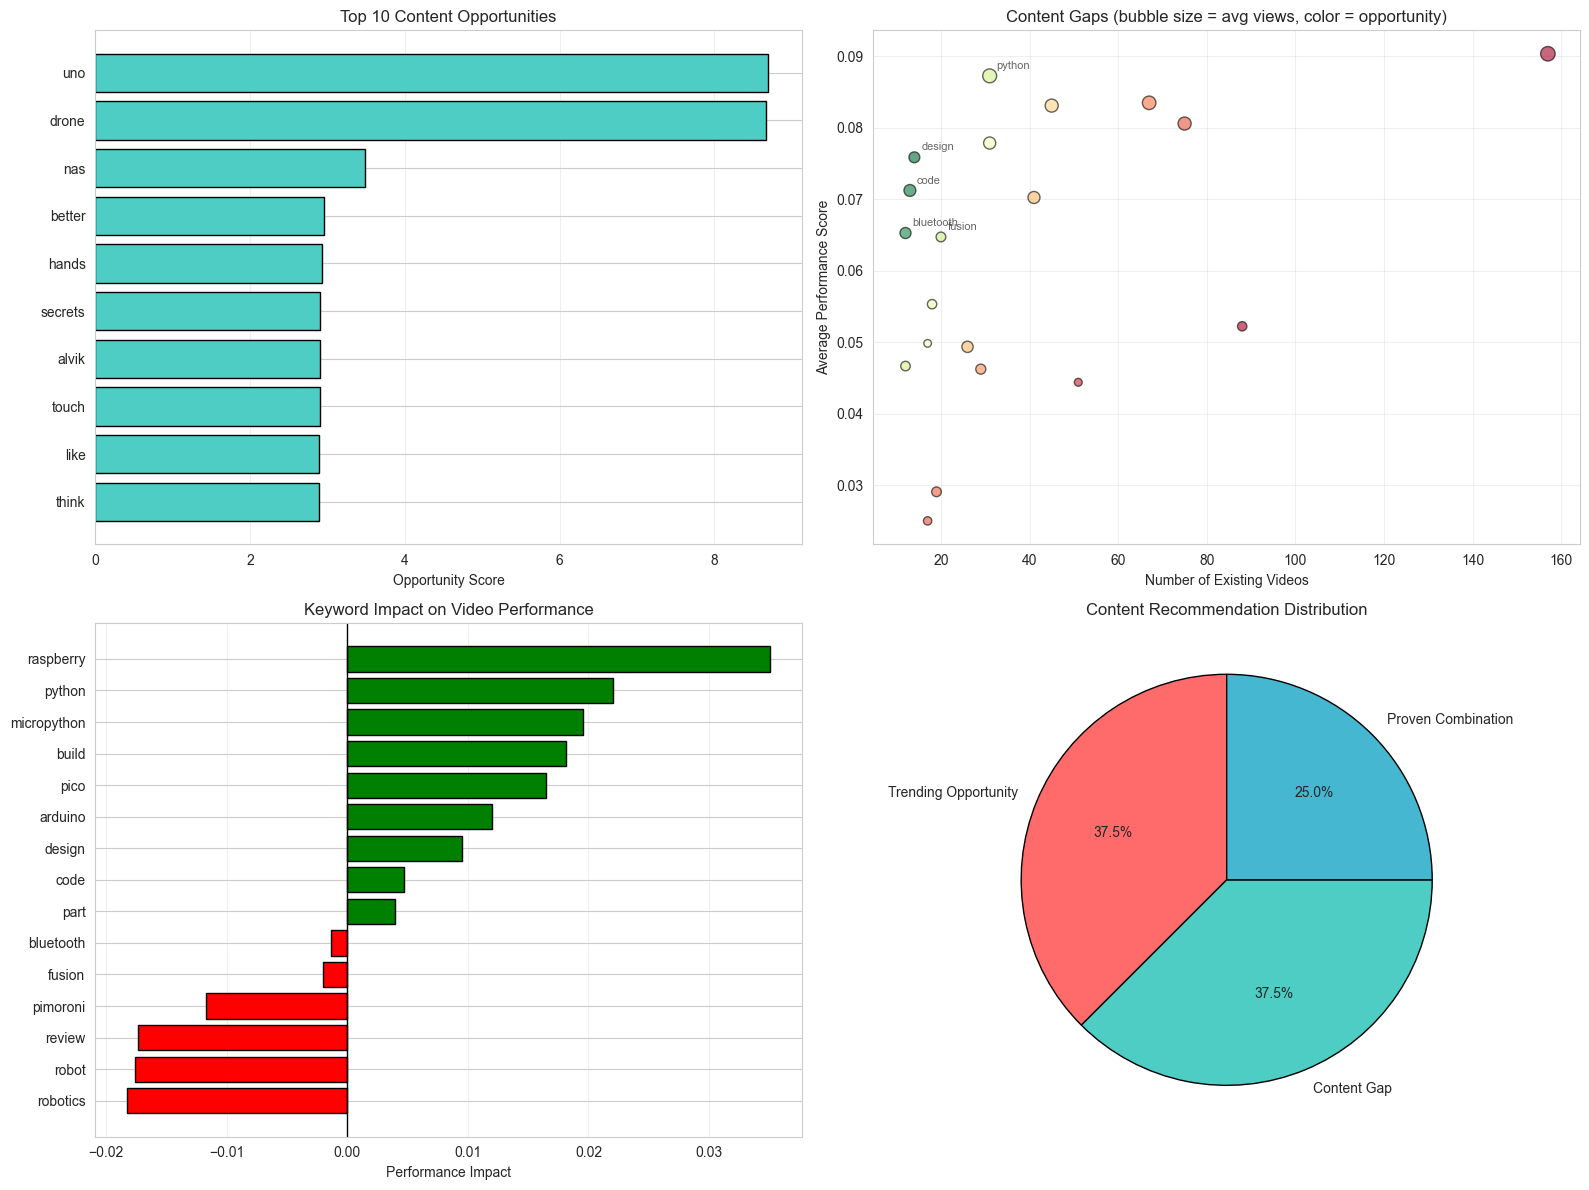

✓ Content strategy dashboard saved as 'content_strategy_dashboard.png'


In [29]:
# Final summary visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Opportunity Score by Keyword
top_opportunities = trending_df_analysis.head(10).sort_values('opportunity_score')
axes[0, 0].barh(top_opportunities['keyword'], top_opportunities['opportunity_score'], 
                color='#4ECDC4', edgecolor='black')
axes[0, 0].set_xlabel('Opportunity Score')
axes[0, 0].set_title('Top 10 Content Opportunities')
axes[0, 0].grid(axis='x', alpha=0.3)

# 2. Gap Analysis - Performance vs Video Count
axes[0, 1].scatter(gap_df['video_count'], gap_df['avg_performance'], 
                   s=gap_df['avg_views']/100, alpha=0.6, c=gap_df['gap_score'],
                   cmap='RdYlGn', edgecolors='black')
axes[0, 1].set_xlabel('Number of Existing Videos')
axes[0, 1].set_ylabel('Average Performance Score')
axes[0, 1].set_title('Content Gaps (bubble size = avg views, color = opportunity)')
axes[0, 1].grid(True, alpha=0.3)

# Add labels for top gaps
for idx, row in gap_df.head(5).iterrows():
    axes[0, 1].annotate(row['keyword'], 
                       (row['video_count'], row['avg_performance']),
                       xytext=(5, 5), textcoords='offset points',
                       fontsize=8, alpha=0.7)

# 3. Keyword Impact Distribution
keyword_impact_top = keyword_impact_df.head(15).sort_values('Performance Impact')
colors_impact = ['green' if x > 0 else 'red' for x in keyword_impact_top['Performance Impact']]
axes[1, 0].barh(keyword_impact_top['Keyword'], keyword_impact_top['Performance Impact'], 
                color=colors_impact, edgecolor='black')
axes[1, 0].set_xlabel('Performance Impact')
axes[1, 0].set_title('Keyword Impact on Video Performance')
axes[1, 0].axvline(x=0, color='black', linestyle='-', linewidth=1)
axes[1, 0].grid(axis='x', alpha=0.3)

# 4. Content Calendar Priority
priority_counts = recommendations_df['type'].value_counts()
axes[1, 1].pie(priority_counts.values, labels=priority_counts.index, autopct='%1.1f%%',
              colors=['#FF6B6B', '#4ECDC4', '#45B7D1'], startangle=90,
              wedgeprops={'edgecolor': 'black', 'linewidth': 1})
axes[1, 1].set_title('Content Recommendation Distribution')

plt.tight_layout()
plt.savefig('content_strategy_dashboard.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Content strategy dashboard saved as 'content_strategy_dashboard.png'")

## 12. Performance Coaching: Areas for Improvement

This section provides personalized coaching based on your actual video performance, showing you exactly where to improve and how.

In [30]:
# Performance Coaching Analysis
print("="*100)
print("PERSONALIZED PERFORMANCE COACHING")
print("="*100)

# Define key performance metrics to coach on
coaching_metrics = {
    'Click-Through Rate (CTR)': {
        'column': 'Impressions click-through rate (%)',
        'good_threshold': 5.0,  # Above 5% is excellent
        'poor_threshold': 2.5,  # Below 2.5% needs work
        'advice': {
            'improve': [
                'Create more compelling thumbnails with bold, readable text',
                'Use faces showing emotion in thumbnails',
                'Write titles that create curiosity or promise specific value',
                'A/B test different thumbnail styles',
                'Study what thumbnails competitors use for similar topics'
            ],
            'maintain': [
                'Continue using your current thumbnail style',
                'Document what makes these thumbnails work',
                'Use this as a template for future videos'
            ]
        }
    },
    'Average View Duration': {
        'column': 'avg_view_duration',
        'good_threshold': 3.5,  # Above 3.5 minutes is good
        'poor_threshold': 1.5,  # Below 1.5 minutes needs work
        'advice': {
            'improve': [
                'Hook viewers in the first 10 seconds - show the end result',
                'Cut out slow introductions and lengthy explanations',
                'Add pattern interrupts (b-roll, animations) every 30 seconds',
                'Remove filler words and dead air in editing',
                'Structure content with clear chapters/sections',
                'Tease what\'s coming next to maintain interest'
            ],
            'maintain': [
                'Your pacing and content structure is working well',
                'Continue providing value throughout the entire video',
                'Maintain your current editing style'
            ]
        }
    },
    'Subscriber Conversion': {
        'column': 'subscriber_conversion',
        'good_threshold': 2.0,  # Above 2% subscriber conversion is excellent
        'poor_threshold': 0.5,  # Below 0.5% needs work
        'advice': {
            'improve': [
                'Add clear calls-to-action to subscribe (verbally + on screen)',
                'Explain the value of subscribing (what they\'ll get)',
                'Place subscribe prompts at high-engagement moments',
                'Create content series that encourage subscription',
                'End with a strong outro showcasing other videos'
            ],
            'maintain': [
                'Your calls-to-action are working effectively',
                'Continue building strong audience relationships',
                'Keep delivering on subscriber expectations'
            ]
        }
    },
    'Views Per Day': {
        'column': 'views_per_day',
        'good_threshold': df['views_per_day'].quantile(0.75),
        'poor_threshold': df['views_per_day'].quantile(0.25),
        'advice': {
            'improve': [
                'Optimize video SEO (title, description, tags)',
                'Share on relevant social media and communities',
                'Create content on trending/evergreen topics',
                'Improve search rankings with better keyword targeting',
                'Cross-promote in your other popular videos'
            ],
            'maintain': [
                'Your content is finding its audience well',
                'Continue your current promotion strategy',
                'Build on this momentum with related content'
            ]
        }
    }
}

print("\nAnalyzing your performance across key metrics...\n")

PERSONALIZED PERFORMANCE COACHING

Analyzing your performance across key metrics...



In [31]:
# For each metric, identify strengths and weaknesses with specific examples
coaching_report = []

for metric_name, metric_info in coaching_metrics.items():
    column = metric_info['column']
    good_threshold = metric_info['good_threshold']
    poor_threshold = metric_info['poor_threshold']
    
    # Find videos that excel in this metric
    excellent_videos = df[df[column] >= good_threshold].nlargest(5, column)
    
    # Find videos that need improvement in this metric
    poor_videos = df[df[column] <= poor_threshold].nsmallest(5, column)
    
    # Calculate your overall performance
    median_value = df[column].median()
    mean_value = df[column].mean()
    
    # Determine status
    if median_value >= good_threshold:
        status = "✅ STRENGTH"
        advice_key = 'maintain'
        color = 'green'
    elif median_value <= poor_threshold:
        status = "⚠️  NEEDS IMPROVEMENT"
        advice_key = 'improve'
        color = 'red'
    else:
        status = "➡️  MODERATE"
        advice_key = 'improve'
        color = 'orange'
    
    coaching_report.append({
        'metric': metric_name,
        'status': status,
        'median': median_value,
        'mean': mean_value,
        'excellent_count': len(excellent_videos),
        'poor_count': len(poor_videos),
        'excellent_videos': excellent_videos,
        'poor_videos': poor_videos,
        'advice': metric_info['advice'][advice_key],
        'color': color
    })
    
    # Print detailed coaching for this metric
    print("="*100)
    print(f"{status}: {metric_name}")
    print("="*100)
    print(f"\nYour Performance:")
    print(f"  • Median: {median_value:.2f}")
    print(f"  • Mean: {mean_value:.2f}")
    print(f"  • Target (Good): ≥ {good_threshold:.2f}")
    print(f"  • Needs Work: ≤ {poor_threshold:.2f}")
    
    # Show percentage distribution
    excellent_pct = (len(excellent_videos) / len(df)) * 100
    poor_pct = (len(poor_videos) / len(df)) * 100
    print(f"  • {excellent_pct:.1f}% of your videos excel in this metric")
    print(f"  • {poor_pct:.1f}% of your videos need improvement in this metric")
    
    print(f"\n📊 EXAMPLES - Videos that EXCEL in {metric_name}:")
    print("-" * 80)
    for idx, video in excellent_videos.head(3).iterrows():
        print(f"\n  ✓ {video['Video title'][:70]}")
        print(f"    {metric_name}: {video[column]:.2f} | Views: {video['Views']:,} | Performance: {video['performance_score']:.3f}")
        
        # Analyze what makes it good
        if column == 'Impressions click-through rate (%)':
            print(f"    Why it works: Strong CTR suggests compelling thumbnail/title combination")
        elif column == 'avg_view_duration':
            retention = (video['avg_view_duration'] / (video['Duration']/60)) * 100 if video['Duration'] > 0 else 0
            print(f"    Why it works: {retention:.1f}% average retention - engaging content throughout")
        elif column == 'subscriber_conversion':
            print(f"    Why it works: {video['Subscribers']:,} new subscribers - strong CTA and value proposition")
        elif column == 'views_per_day':
            print(f"    Why it works: Evergreen topic or excellent SEO - {video['views_per_day']:.1f} views/day")
    
    if len(poor_videos) > 0:
        print(f"\n📉 EXAMPLES - Videos that need improvement in {metric_name}:")
        print("-" * 80)
        for idx, video in poor_videos.head(3).iterrows():
            print(f"\n  ✗ {video['Video title'][:70]}")
            print(f"    {metric_name}: {video[column]:.2f} | Views: {video['Views']:,} | Performance: {video['performance_score']:.3f}")
            
            # Diagnose the issue
            if column == 'Impressions click-through rate (%)':
                print(f"    Issue: Low CTR ({video[column]:.2f}%) - thumbnail/title not compelling enough")
                print(f"    Impressions received: {video['Impressions']:,.0f} - but only {video[column]:.2f}% clicked")
            elif column == 'avg_view_duration':
                retention = (video['avg_view_duration'] / (video['Duration']/60)) * 100 if video['Duration'] > 0 else 0
                print(f"    Issue: Only {retention:.1f}% average retention - viewers dropping off early")
                print(f"    Video length: {video['Duration']/60:.1f} min, but viewers watch {video['avg_view_duration']:.1f} min avg")
            elif column == 'subscriber_conversion':
                print(f"    Issue: Only {video['Subscribers']:,} new subscribers from {video['Views']:,} views")
                print(f"    Conversion rate: {video['subscriber_conversion']:.2f}% - weak CTA or unclear value")
            elif column == 'views_per_day':
                print(f"    Issue: Only {video['views_per_day']:.1f} views/day - poor discoverability")
                print(f"    Age: {video['days_since_publish']:,.0f} days old with {video['Views']:,} total views")
    
    print(f"\n💡 ACTION ITEMS - How to improve your {metric_name}:")
    print("-" * 80)
    for i, advice in enumerate(metric_info['advice'][advice_key], 1):
        print(f"  {i}. {advice}")
    
    print("\n")

➡️  MODERATE: Click-Through Rate (CTR)

Your Performance:
  • Median: 2.89
  • Mean: 3.24
  • Target (Good): ≥ 5.00
  • Needs Work: ≤ 2.50
  • 1.0% of your videos excel in this metric
  • 1.0% of your videos need improvement in this metric

📊 EXAMPLES - Videos that EXCEL in Click-Through Rate (CTR):
--------------------------------------------------------------------------------

  ✓ Learn python for SMARS robot - GIT & SOURCE CODE CONTROL
    Click-Through Rate (CTR): 20.10 | Views: 2,552.0 | Performance: 0.123
    Why it works: Strong CTR suggests compelling thumbnail/title combination

  ✓ Raspberry Pi 4 & VS Code
    Click-Through Rate (CTR): 9.49 | Views: 32,192.0 | Performance: 0.187
    Why it works: Strong CTR suggests compelling thumbnail/title combination

  ✓ Hewenden Viaduct
    Click-Through Rate (CTR): 9.49 | Views: 239.0 | Performance: 0.058
    Why it works: Strong CTR suggests compelling thumbnail/title combination

📉 EXAMPLES - Videos that need improvement in Click-Th

In [32]:
# Create a prioritized improvement plan
print("="*100)
print("PRIORITIZED IMPROVEMENT PLAN")
print("="*100)

# Calculate impact potential for each weak area
improvement_priorities = []

for report in coaching_report:
    if report['status'] in ["⚠️  NEEDS IMPROVEMENT", "➡️  MODERATE"]:
        # Calculate potential impact
        # Higher poor_count = more videos could benefit
        # Lower median = more room for improvement
        target = None
        for metric_name, metric_info in coaching_metrics.items():
            if metric_name == report['metric']:
                target = metric_info['good_threshold']
                break
        
        if target:
            improvement_potential = (target - report['median']) / target * 100
            impact_score = (report['poor_count'] / len(df)) * improvement_potential
            
            improvement_priorities.append({
                'metric': report['metric'],
                'current_median': report['median'],
                'target': target,
                'improvement_potential': improvement_potential,
                'videos_affected': report['poor_count'],
                'impact_score': impact_score,
                'top_action': report['advice'][0] if report['advice'] else 'Review performance'
            })

# Sort by impact score
improvement_priorities_df = pd.DataFrame(improvement_priorities).sort_values('impact_score', ascending=False)

if len(improvement_priorities_df) > 0:
    print("\nFocus on these areas first (ordered by potential impact):\n")
    
    for i, row in improvement_priorities_df.iterrows():
        print(f"{row['metric']}:")
        print(f"  Current: {row['current_median']:.2f} → Target: {row['target']:.2f}")
        print(f"  Improvement potential: {row['improvement_potential']:.1f}%")
        print(f"  Videos that could improve: {row['videos_affected']:.0f}")
        print(f"  Impact Score: {row['impact_score']:.1f}")
        print(f"  Priority Action: {row['top_action']}")
        print()
    
    # Export improvement plan
    improvement_priorities_df.to_csv('improvement_plan.csv', index=False)
    print("✓ Improvement plan saved to 'improvement_plan.csv'")
else:
    print("\n🎉 Congratulations! All your key metrics are performing well!")
    print("Focus on maintaining your current standards and experimenting with new content.")

print("\n" + "="*100)

PRIORITIZED IMPROVEMENT PLAN

Focus on these areas first (ordered by potential impact):

Subscriber Conversion:
  Current: 0.73 → Target: 2.00
  Improvement potential: 63.7%
  Videos that could improve: 5
  Impact Score: 0.7
  Priority Action: Add clear calls-to-action to subscribe (verbally + on screen)

Views Per Day:
  Current: 3.70 → Target: 9.47
  Improvement potential: 60.9%
  Videos that could improve: 5
  Impact Score: 0.6
  Priority Action: Optimize video SEO (title, description, tags)

Click-Through Rate (CTR):
  Current: 2.89 → Target: 5.00
  Improvement potential: 42.2%
  Videos that could improve: 5
  Impact Score: 0.4
  Priority Action: Create more compelling thumbnails with bold, readable text

✓ Improvement plan saved to 'improvement_plan.csv'



In [33]:
# Comparative Analysis - Learn from your best
print("\n")
print("="*100)
print("LEARN FROM YOUR BEST: Side-by-Side Comparison")
print("="*100)

print("\nComparing your TOP 10 vs BOTTOM 10 performers across all metrics:\n")

top_10_all = df.nlargest(10, 'performance_score')
bottom_10_all = df.nsmallest(10, 'performance_score')

comparison_metrics = {
    'CTR': 'Impressions click-through rate (%)',
    'Avg View Duration (min)': 'avg_view_duration',
    'Subscriber Conversion': 'subscriber_conversion',
    'Views/Day': 'views_per_day',
    'Video Length (min)': lambda x: x['Duration'] / 60,
}

print(f"{'Metric':<30} {'Top 10 Avg':<15} {'Bottom 10 Avg':<15} {'Difference':<15} {'What to Learn'}")
print("-" * 110)

insights = []

for metric_name, metric_ref in comparison_metrics.items():
    if callable(metric_ref):
        top_val = top_10_all.apply(metric_ref, axis=1).mean()
        bottom_val = bottom_10_all.apply(metric_ref, axis=1).mean()
    else:
        top_val = top_10_all[metric_ref].mean()
        bottom_val = bottom_10_all[metric_ref].mean()
    
    diff = top_val - bottom_val
    diff_pct = (diff / bottom_val * 100) if bottom_val != 0 else 0
    
    # Generate insight
    if metric_name == 'CTR':
        if diff > 2:
            insight = "Better thumbnails/titles"
        else:
            insight = "Similar appeal"
    elif metric_name == 'Avg View Duration (min)':
        if diff > 1:
            insight = "More engaging content"
        else:
            insight = "Similar retention"
    elif metric_name == 'Subscriber Conversion':
        if diff > 0.5:
            insight = "Stronger CTAs"
        else:
            insight = "Similar conversion"
    elif metric_name == 'Views/Day':
        if diff > 10:
            insight = "Better SEO/promotion"
        else:
            insight = "Similar reach"
    elif metric_name == 'Video Length (min)':
        if abs(diff) > 5:
            if diff > 0:
                insight = "Longer works better"
            else:
                insight = "Shorter works better"
        else:
            insight = "Length not critical"
    else:
        insight = ""
    
    insights.append({
        'metric': metric_name,
        'top_avg': top_val,
        'bottom_avg': bottom_val,
        'difference': diff,
        'diff_pct': diff_pct,
        'insight': insight
    })
    
    print(f"{metric_name:<30} {top_val:<15.2f} {bottom_val:<15.2f} {diff:+<15.2f} {insight}")

print("\n")

# Identify your unique success pattern
print("="*100)
print("YOUR UNIQUE SUCCESS PATTERN")
print("="*100)

print("\nAnalyzing what makes YOUR successful videos different from typical advice...\n")

# Get common keywords in top performers
top_20_keywords = []
for keywords in top_20_performers['keywords']:
    top_20_keywords.extend(keywords)
top_keyword_counts = Counter(top_20_keywords)

# Get common keywords in bottom performers  
bottom_20 = df.nsmallest(20, 'performance_score')
bottom_keywords = []
for keywords in bottom_20['keywords']:
    bottom_keywords.extend(keywords)
bottom_keyword_counts = Counter(bottom_keywords)

# Find keywords that appear disproportionately in top vs bottom
success_keywords = []
for keyword, top_count in top_keyword_counts.most_common(20):
    bottom_count = bottom_keyword_counts.get(keyword, 0)
    
    # Calculate ratio
    top_freq = top_count / len(top_20_performers)
    bottom_freq = bottom_count / len(bottom_20) if len(bottom_20) > 0 else 0.01
    
    if top_freq > 0.2 and top_freq / (bottom_freq + 0.01) > 2:  # Appears in >20% of top, 2x more than bottom
        success_keywords.append({
            'keyword': keyword,
            'top_freq': top_freq * 100,
            'bottom_freq': bottom_freq * 100,
            'ratio': top_freq / (bottom_freq + 0.01)
        })

if success_keywords:
    print("Keywords that appear MORE in your TOP performers:\n")
    for kw in sorted(success_keywords, key=lambda x: x['ratio'], reverse=True)[:8]:
        print(f"  • {kw['keyword'].upper()}")
        print(f"    Top videos: {kw['top_freq']:.0f}% | Bottom videos: {kw['bottom_freq']:.0f}%")
        print(f"    You're {kw['ratio']:.1f}x more successful when covering this topic")
        print()

print("\n💎 KEY INSIGHT: Your audience responds best to these topics - double down on them!")



LEARN FROM YOUR BEST: Side-by-Side Comparison

Comparing your TOP 10 vs BOTTOM 10 performers across all metrics:

Metric                         Top 10 Avg      Bottom 10 Avg   Difference      What to Learn
--------------------------------------------------------------------------------------------------------------
CTR                            5.43            0.83            4.59+++++++++++ Better thumbnails/titles
Avg View Duration (min)        5.69            1.02            4.67+++++++++++ More engaging content
Subscriber Conversion          1.37            0.01            1.35+++++++++++ Stronger CTAs
Views/Day                      79.63           0.72            78.90++++++++++ Better SEO/promotion
Video Length (min)             55.93           5.40            50.53++++++++++ Longer works better


YOUR UNIQUE SUCCESS PATTERN

Analyzing what makes YOUR successful videos different from typical advice...

Keywords that appear MORE in your TOP performers:

  • RASPBERRY
    Top v

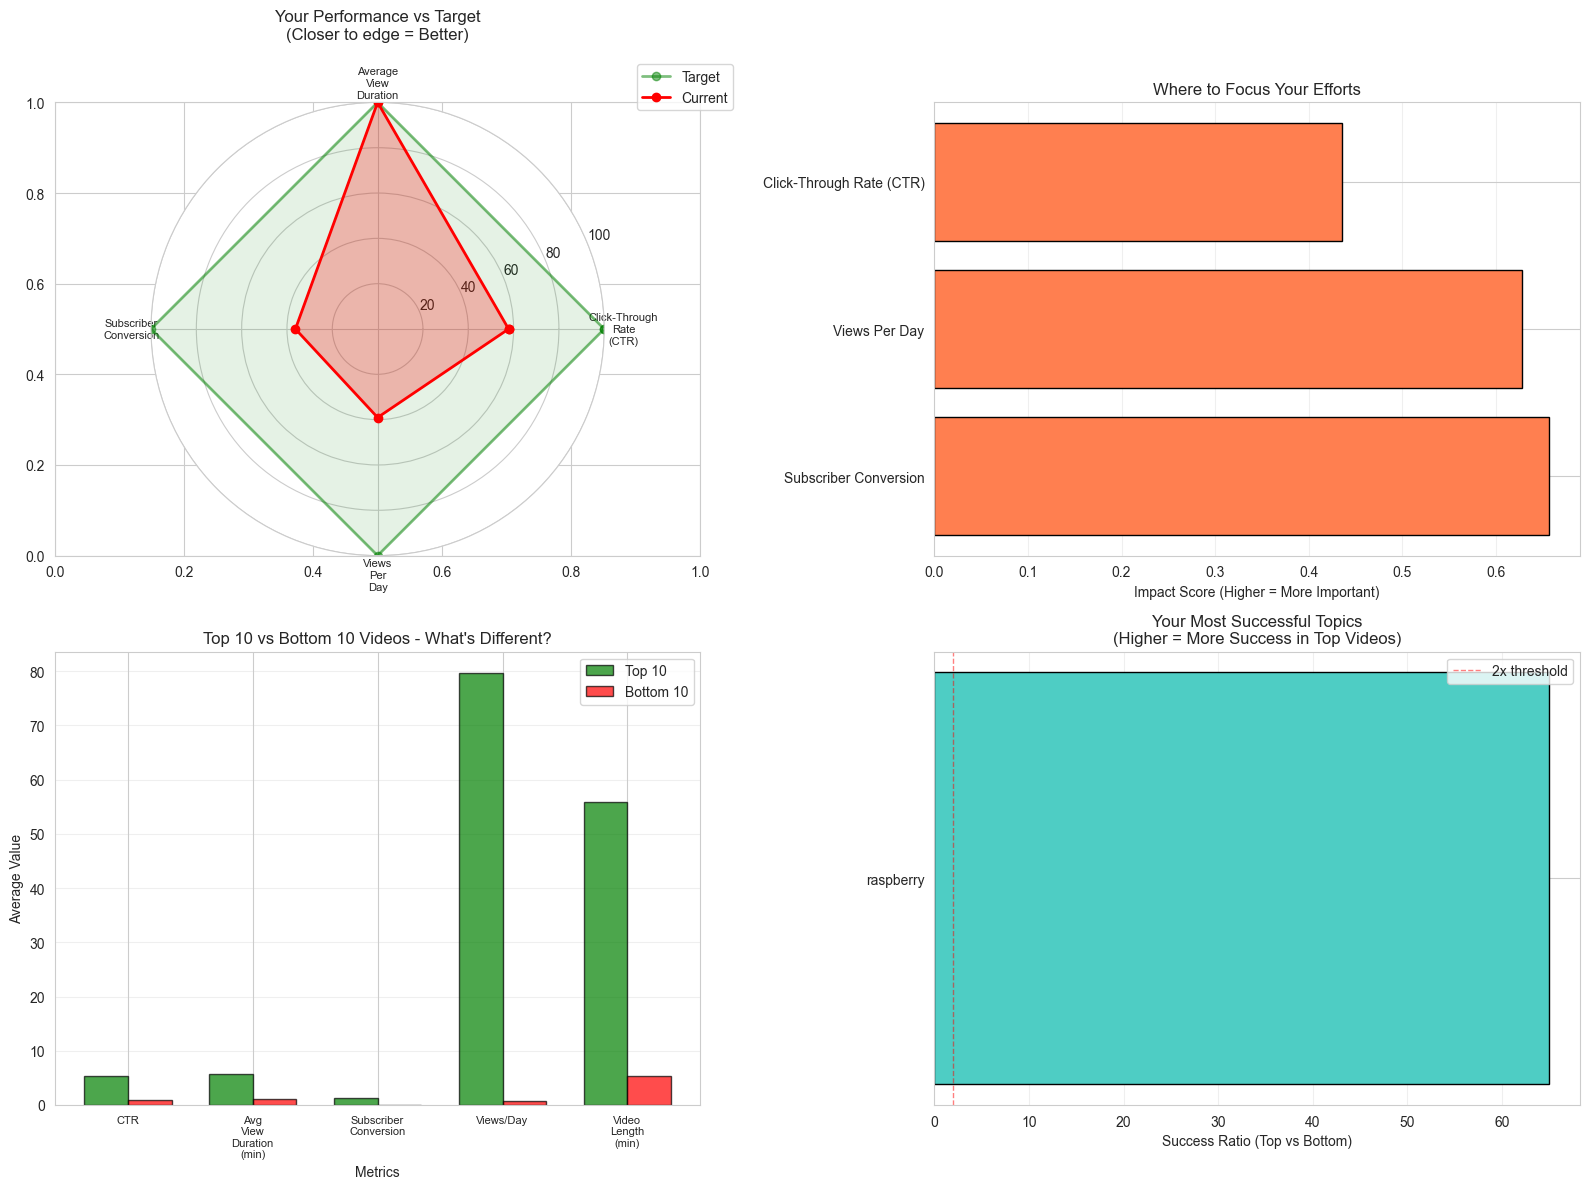


✓ Coaching dashboard saved as 'coaching_dashboard.png'


In [34]:
# Create coaching visualization dashboard
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Performance Metrics Radar Chart (Your current vs Target)
from math import pi

if len(coaching_report) > 0:
    categories = [r['metric'] for r in coaching_report]
    
    # Normalize all values to 0-100 scale for comparison
    current_values = []
    target_values = []
    
    for report in coaching_report:
        # Get target from original coaching_metrics
        for metric_name, metric_info in coaching_metrics.items():
            if metric_name == report['metric']:
                target = metric_info['good_threshold']
                # Normalize: current as % of target (cap at 100%)
                normalized_current = min((report['median'] / target) * 100, 100)
                current_values.append(normalized_current)
                target_values.append(100)  # Target is always 100%
                break
    
    # Number of variables
    N = len(categories)
    
    # Angle for each axis
    angles = [n / float(N) * 2 * pi for n in range(N)]
    current_values += current_values[:1]
    target_values += target_values[:1]
    angles += angles[:1]
    
    # Plot
    ax = plt.subplot(221, polar=True)
    ax.plot(angles, target_values, 'o-', linewidth=2, label='Target', color='green', alpha=0.5)
    ax.fill(angles, target_values, alpha=0.1, color='green')
    ax.plot(angles, current_values, 'o-', linewidth=2, label='Current', color='red')
    ax.fill(angles, current_values, alpha=0.25, color='red')
    
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels([c.replace(' ', '\n') for c in categories], size=8)
    ax.set_ylim(0, 100)
    ax.set_title('Your Performance vs Target\n(Closer to edge = Better)', size=12, pad=20)
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    ax.grid(True)

# 2. Improvement Impact Scores
if len(improvement_priorities_df) > 0:
    axes[0, 1].barh(improvement_priorities_df['metric'], 
                    improvement_priorities_df['impact_score'],
                    color='coral', edgecolor='black')
    axes[0, 1].set_xlabel('Impact Score (Higher = More Important)')
    axes[0, 1].set_title('Where to Focus Your Efforts')
    axes[0, 1].grid(axis='x', alpha=0.3)
else:
    axes[0, 1].text(0.5, 0.5, 'All metrics performing well!\n🎉', 
                    ha='center', va='center', fontsize=16, transform=axes[0, 1].transAxes)
    axes[0, 1].set_title('Performance Status')
    axes[0, 1].axis('off')

# 3. Top vs Bottom - Key Metrics Comparison
if insights:
    insights_df = pd.DataFrame(insights)
    x = np.arange(len(insights_df))
    width = 0.35
    
    axes[1, 0].bar(x - width/2, insights_df['top_avg'], width, label='Top 10', 
                   color='green', alpha=0.7, edgecolor='black')
    axes[1, 0].bar(x + width/2, insights_df['bottom_avg'], width, label='Bottom 10',
                   color='red', alpha=0.7, edgecolor='black')
    
    axes[1, 0].set_xlabel('Metrics')
    axes[1, 0].set_ylabel('Average Value')
    axes[1, 0].set_title('Top 10 vs Bottom 10 Videos - What\'s Different?')
    axes[1, 0].set_xticks(x)
    axes[1, 0].set_xticklabels([i['metric'].replace(' ', '\n') for i in insights], 
                               rotation=0, ha='center', fontsize=8)
    axes[1, 0].legend()
    axes[1, 0].grid(axis='y', alpha=0.3)

# 4. Success Pattern - Topic Performance
if success_keywords:
    success_kw_df = pd.DataFrame(success_keywords).head(8).sort_values('ratio')
    
    axes[1, 1].barh(success_kw_df['keyword'], success_kw_df['ratio'],
                    color='#4ECDC4', edgecolor='black')
    axes[1, 1].set_xlabel('Success Ratio (Top vs Bottom)')
    axes[1, 1].set_title('Your Most Successful Topics\n(Higher = More Success in Top Videos)')
    axes[1, 1].grid(axis='x', alpha=0.3)
    axes[1, 1].axvline(x=2, color='red', linestyle='--', linewidth=1, alpha=0.5,
                       label='2x threshold')
    axes[1, 1].legend()
else:
    axes[1, 1].text(0.5, 0.5, 'No clear topic pattern found', 
                    ha='center', va='center', fontsize=12, transform=axes[1, 1].transAxes)
    axes[1, 1].set_title('Topic Success Pattern')
    axes[1, 1].axis('off')

plt.tight_layout()
plt.savefig('coaching_dashboard.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Coaching dashboard saved as 'coaching_dashboard.png'")

In [35]:
# Export comprehensive coaching report
print("\n" + "="*100)
print("EXPORTING COACHING MATERIALS")
print("="*100)

# Create a detailed coaching report export
coaching_export = []

for report in coaching_report:
    for i, (idx, video) in enumerate(report['excellent_videos'].head(3).iterrows()):
        coaching_export.append({
            'Metric': report['metric'],
            'Performance': 'EXCELLENT',
            'Video Title': video['Video title'],
            'Metric Value': video[coaching_metrics[report['metric']]['column']],
            'Views': video['Views'],
            'Performance Score': video['performance_score'],
            'Study This': 'Yes - replicate success factors'
        })
    
    if len(report['poor_videos']) > 0:
        for i, (idx, video) in enumerate(report['poor_videos'].head(3).iterrows()):
            coaching_export.append({
                'Metric': report['metric'],
                'Performance': 'NEEDS WORK',
                'Video Title': video['Video title'],
                'Metric Value': video[coaching_metrics[report['metric']]['column']],
                'Views': video['Views'],
                'Performance Score': video['performance_score'],
                'Study This': 'Yes - identify what to avoid'
            })

coaching_export_df = pd.DataFrame(coaching_export)
coaching_export_df.to_csv('coaching_examples.csv', index=False)
print("\n✓ Detailed coaching examples saved to 'coaching_examples.csv'")
print("  (Compare excellent vs poor performers for each metric)")

# Create action checklist
action_items = []
priority = 1

for i, row in improvement_priorities_df.iterrows():
    # Get the advice list for this metric
    for report in coaching_report:
        if report['metric'] == row['metric']:
            for advice in report['advice']:
                action_items.append({
                    'Priority': priority,
                    'Focus Area': row['metric'],
                    'Current Performance': row['current_median'],
                    'Target': row['target'],
                    'Action Item': advice,
                    'Status': 'Not Started'
                })
            priority += 1
            break

if action_items:
    action_items_df = pd.DataFrame(action_items)
    action_items_df.to_csv('action_checklist.csv', index=False)
    print("✓ Action checklist saved to 'action_checklist.csv'")
    print("  (Track your progress on improvement tasks)")
    
    print(f"\n📋 Total action items to work on: {len(action_items)}")

print("\n" + "="*100)
print("\n🎯 FINAL COACHING SUMMARY:")
print("-" * 100)

# Count strengths vs weaknesses
strengths = sum(1 for r in coaching_report if r['status'] == "✅ STRENGTH")
needs_improvement = sum(1 for r in coaching_report if r['status'] == "⚠️  NEEDS IMPROVEMENT")
moderate = sum(1 for r in coaching_report if r['status'] == "➡️  MODERATE")

print(f"\nYour Performance Overview:")
print(f"  ✅ Strengths: {strengths}/{len(coaching_report)} metrics")
print(f"  ➡️  Moderate: {moderate}/{len(coaching_report)} metrics")
print(f"  ⚠️  Needs Work: {needs_improvement}/{len(coaching_report)} metrics")

if len(improvement_priorities_df) > 0:
    print(f"\nTop Priority: Focus on improving {improvement_priorities_df.iloc[0]['metric']}")
    print(f"  → {improvement_priorities_df.iloc[0]['top_action']}")

print("\n📚 Files created for your coaching journey:")
print("  • coaching_examples.csv - Specific videos to study")
print("  • action_checklist.csv - Step-by-step improvement tasks")
print("  • improvement_plan.csv - Prioritized areas to focus on")
print("  • coaching_dashboard.png - Visual performance overview")

print("\n💪 Remember: Small improvements in each area compound to major channel growth!")
print("="*100)


EXPORTING COACHING MATERIALS

✓ Detailed coaching examples saved to 'coaching_examples.csv'
  (Compare excellent vs poor performers for each metric)
✓ Action checklist saved to 'action_checklist.csv'
  (Track your progress on improvement tasks)

📋 Total action items to work on: 15


🎯 FINAL COACHING SUMMARY:
----------------------------------------------------------------------------------------------------

Your Performance Overview:
  ✅ Strengths: 1/4 metrics
  ➡️  Moderate: 3/4 metrics
  ⚠️  Needs Work: 0/4 metrics

Top Priority: Focus on improving Subscriber Conversion
  → Add clear calls-to-action to subscribe (verbally + on screen)

📚 Files created for your coaching journey:
  • coaching_examples.csv - Specific videos to study
  • action_checklist.csv - Step-by-step improvement tasks
  • improvement_plan.csv - Prioritized areas to focus on
  • coaching_dashboard.png - Visual performance overview

💪 Remember: Small improvements in each area compound to major channel growth!


## Summary

This analysis has provided comprehensive insights into your YouTube channel performance:

### Key Deliverables:
1. **Performance Analysis**: Videos clustered into 5 distinct performance groups
2. **Success Factors**: Identified metrics and keywords that drive high performance
3. **Trending Topics**: Discovered which topics are gaining momentum recently
4. **Content Strategy**: Generated specific video title suggestions and topic recommendations
5. **Content Calendar**: 8-week prioritized plan based on data-driven opportunities

### Export Files Created:
- `youtube_analysis_results.csv` - Complete video performance data with cluster assignments
- `cluster_summary.csv` - Cluster characteristics and statistics
- `trending_keywords.csv` - Trending keywords with scores
- `content_recommendations.csv` - Prioritized content opportunities
- `suggested_titles.csv` - Ready-to-use video title suggestions
- `content_strategy_dashboard.png` - Visual summary of content opportunities

### Next Steps:
1. Review the suggested titles and select topics that align with your expertise
2. Focus on trending opportunities with low video count (highest ROI)
3. Replicate the characteristics of your top-performing cluster
4. Maintain the optimal video duration and CTR targets identified
5. Monitor which new videos fall into high-performing clusters

The data shows clear patterns in what works for your audience - use these insights to guide your content strategy!